# CarND Object Detection Lab

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm
from keras.models import load_model
import cv2
%matplotlib inline
plt.style.use('ggplot')


Using TensorFlow backend.


JPEG
image size (1000, 712)
image_na.shape (712, 1000, 3)
img_light.shape= (1, 32, 32, 3)


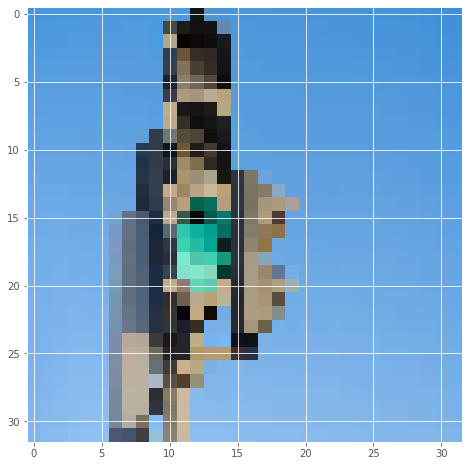

In [2]:
# Load a sample image.
image = Image.open('./assets/light.jpg')
#image = Image.open('~/Qis_learning/Self_driving_engineer/Capstone/CarND-Capstone-3/imgs/trafficlights/StopLightImage_1.png')
print(image.format)
# image = image[0:3]
image_na = np.asarray(image, dtype=np.uint8)
# image_na = cv2.cvtColor(image_na, cv2.COLOR_BGR2RGB)
print('image size', image.size)
print('image_na.shape', image_na.shape)
img_light = cv2.resize(image_na, (32,32))
plt.figure(figsize=(12, 8))
plt.imshow(img_light)
img_light = np.expand_dims(np.asarray(img_light, dtype=np.uint8), 0)
print('img_light.shape=', img_light.shape)
# image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
# print('image_np.shape=', image_np.shape)
# plt.figure(figsize=(12, 8))
# plt.imshow(image) 

In [ ]:
light_model = load_model('./assets/tl_model_5.h5')
graph = tf.get_default_graph()
with graph.as_default():
    light_predict = light_model.predict(img_light)
    print('light_predict =', light_predict)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/anaconda3/envs/self_drving_env/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## MobileNets

[*MobileNets*](https://arxiv.org/abs/1704.04861), as the name suggests, are neural networks constructed for the purpose of running very efficiently (high FPS, low memory footprint) on mobile and embedded devices. *MobileNets* achieve this with 3 techniques:

1. Perform a depthwise convolution followed by a 1x1 convolution rather than a standard convolution. The 1x1 convolution is called a pointwise convolution if it's following a depthwise convolution. The combination of a depthwise convolution followed by a pointwise convolution is sometimes called a separable depthwise convolution.
2. Use a "width multiplier" - reduces the size of the input/output channels, set to a value between 0 and 1.
3. Use a "resolution multiplier" - reduces the size of the original input, set to a value between 0 and 1.

These 3 techniques reduce the size of cummulative parameters and therefore the computation required. Of course, generally models with more paramters achieve a higher accuracy. *MobileNets* are no silver bullet, while they perform very well larger models will outperform them. ** *MobileNets* are designed for mobile devices, NOT cloud GPUs**. The reason we're using them in this lab is automotive hardware is closer to mobile or embedded devices than beefy cloud GPUs.

### Convolutions

#### Vanilla Convolution

Before we get into the *MobileNet* convolution block let's take a step back and recall the computational cost of a vanilla convolution. There are $N$ kernels of size $D_k * D_k$. Each of these kernels goes over the entire input which is a $D_f * D_f * M$ sized feature map or tensor (if that makes more sense). The computational cost is:

$$
D_g * D_g * M * N * D_k * D_k
$$

Let $D_g * D_g$ be the size of the output feature map. Then a standard convolution takes in a $D_f * D_f * M$ input feature map and returns a $D_g * D_g * N$ feature map as output.

(*Note*: In the MobileNets paper, you may notice the above equation for computational cost uses $D_f$ instead of $D_g$. In the paper, they assume the output and input are the same spatial dimensions due to stride of 1 and padding, so doing so does not make a difference, but this would want $D_g$ for different dimensions of input and output.)

![Standard Convolution](assets/standard_conv.png)



#### Depthwise Convolution

A depthwise convolution acts on each input channel separately with a different kernel. $M$ input channels implies there are $M$ $D_k * D_k$ kernels. Also notice this results in $N$ being set to 1. If this doesn't make sense, think about the shape a kernel would have to be to act upon an individual channel.

Computation cost:

$$
D_g * D_g * M * D_k * D_k
$$


![Depthwise Convolution](assets/depthwise_conv.png)


#### Pointwise Convolution

A pointwise convolution performs a 1x1 convolution, it's the same as a vanilla convolution except the kernel size is $1 * 1$.

Computation cost:

$$
D_k * D_k * D_g * D_g * M * N =
1 * 1 * D_g * D_g * M * N =
D_g * D_g * M * N
$$

![Pointwise Convolution](assets/pointwise_conv.png)



Thus the total computation cost is for separable depthwise convolution:

$$
D_g * D_g * M * D_k * D_k + D_g * D_g * M * N
$$

which results in $\frac{1}{N} + \frac{1}{D_k^2}$ reduction in computation:

$$
\frac {D_g * D_g * M * D_k * D_k + D_g * D_g * M * N} {D_g * D_g * M * N * D_k * D_k} = 
\frac {D_k^2 + N} {D_k^2*N} = 
\frac {1}{N} + \frac{1}{D_k^2}
$$

*MobileNets* use a 3x3 kernel, so assuming a large enough $N$, separable depthwise convnets are ~9x more computationally efficient than vanilla convolutions!

### Width Multiplier

The 2nd technique for reducing the computational cost is the "width multiplier" which is a hyperparameter inhabiting the range [0, 1] denoted here as $\alpha$. $\alpha$ reduces the number of input and output channels proportionally:

$$
D_f * D_f * \alpha M * D_k * D_k + D_f * D_f * \alpha M * \alpha N
$$

### Resolution Multiplier

The 3rd technique for reducing the computational cost is the "resolution multiplier" which is a hyperparameter inhabiting the range [0, 1] denoted here as $\rho$. $\rho$ reduces the size of the input feature map:

$$
\rho D_f * \rho D_f * M * D_k * D_k + \rho D_f * \rho D_f * M * N
$$

Combining the width and resolution multipliers results in a computational cost of:

$$
\rho D_f * \rho D_f * a M * D_k * D_k + \rho D_f * \rho D_f * a M * a N
$$

Training *MobileNets* with different values of $\alpha$ and $\rho$ will result in different speed vs. accuracy tradeoffs. The folks at Google have run these experiments, the result are shown in the graphic below:

![MobileNets Graphic](https://github.com/tensorflow/models/raw/master/research/slim/nets/mobilenet_v1.png)

MACs (M) represents the number of multiplication-add operations in the millions.

### Exercise 1 - Implement Separable Depthwise Convolution

In this exercise you'll implement a separable depthwise convolution block and compare the number of parameters to a standard convolution block. For this exercise we'll assume the width and resolution multipliers are set to 1.

Docs:

* [depthwise convolution](https://www.tensorflow.org/api_docs/python/tf/nn/depthwise_conv2d)

In [ ]:
def vanilla_conv_block(x, kernel_size, output_channels):
    """
    Vanilla Conv -> Batch Norm -> ReLU
    """
    x = tf.layers.conv2d(
        x, output_channels, kernel_size, (2, 2), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

# TODO: implement MobileNet conv block
def mobilenet_conv_block(x, kernel_size, output_channels):
    """
    Depthwise Conv -> Batch Norm -> ReLU -> Pointwise Conv -> Batch Norm -> ReLU
    """
    #pass
    
    # assumes BHWC format
    input_channel_dim = x.get_shape().as_list()[-1] 
    W = tf.Variable(tf.truncated_normal((kernel_size, kernel_size, input_channel_dim, 1)))

    # depthwise conv
    x = tf.nn.depthwise_conv2d(x, W, (1, 2, 2, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    x = tf.nn.relu(x)

    # pointwise conv
    x = tf.layers.conv2d(x, output_channels, (1, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

**[Sample solution](./exercise-solutions/e1.py)**

Let's compare the number of parameters in each block.

In [ ]:
# constants but you can change them so I guess they're not so constant :)
INPUT_CHANNELS = 32
OUTPUT_CHANNELS = 512
KERNEL_SIZE = 3
IMG_HEIGHT = 256
IMG_WIDTH = 256

with tf.Session(graph=tf.Graph()) as sess:
    # input
    x = tf.constant(np.random.randn(1, IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), dtype=tf.float32)

    with tf.variable_scope('vanilla'):
        vanilla_conv = vanilla_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)
    with tf.variable_scope('mobile'):
        mobilenet_conv = mobilenet_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)

    vanilla_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla')
    ]
    mobile_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'mobile')
    ]

    print("VANILLA CONV BLOCK")
    total_vanilla_params = sum([p[1] for p in vanilla_params])
    for p in vanilla_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_vanilla_params)
    print()

    print("MOBILENET CONV BLOCK")
    total_mobile_params = sum([p[1] for p in mobile_params])
    for p in mobile_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_mobile_params)
    print()

    print("{0:.3f}x parameter reduction".format(total_vanilla_params /
                                             total_mobile_params))

Your solution should show the majority of the parameters in *MobileNet* block stem from the pointwise convolution.

## *MobileNet* SSD

In this section you'll use a pretrained *MobileNet* [SSD](https://arxiv.org/abs/1512.02325) model to perform object detection. You can download the *MobileNet* SSD and other models from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) (*note*: we'll provide links to specific models further below). [Paper](https://arxiv.org/abs/1611.10012) describing comparing several object detection models.

Alright, let's get into SSD!

### Single Shot Detection (SSD)

Many previous works in object detection involve more than one training phase. For example, the [Faster-RCNN](https://arxiv.org/abs/1506.01497) architecture first trains a Region Proposal Network (RPN) which decides which regions of the image are worth drawing a box around. RPN is then merged with a pretrained model for classification (classifies the regions). The image below is an RPN:

![Faster-RCNN Visual](./assets/faster-rcnn.png)

The SSD architecture is a single convolutional network which learns to predict bounding box locations and classify the locations in one pass. Put differently, SSD can be trained end to end while Faster-RCNN cannot. The SSD architecture consists of a base network followed by several convolutional layers: 

![SSD Visual](./assets/ssd_architecture.png)

**NOTE:** In this lab the base network is a MobileNet (instead of VGG16.)

#### Detecting Boxes

SSD operates on feature maps to predict bounding box locations. Recall a feature map is of size $D_f * D_f * M$. For each feature map location $k$ bounding boxes are predicted. Each bounding box carries with it the following information:

* 4 corner bounding box **offset** locations $(cx, cy, w, h)$
* $C$ class probabilities $(c_1, c_2, ..., c_p)$

SSD **does not** predict the shape of the box, rather just where the box is. The $k$ bounding boxes each have a predetermined shape. This is illustrated in the figure below:

![](./assets/ssd_feature_maps.png)

The shapes are set prior to actual training. For example, In figure (c) in the above picture there are 4 boxes, meaning $k$ = 4.

### Exercise 2 - SSD Feature Maps

It would be a good exercise to read the SSD paper prior to a answering the following questions.

***Q: Why does SSD use several differently sized feature maps to predict detections?***

A: Your answer here

**[Sample answer](./exercise-solutions/e2.md)**

The current approach leaves us with thousands of bounding box candidates, clearly the vast majority of them are nonsensical.

### Exercise 3 - Filtering Bounding Boxes

***Q: What are some ways which we can filter nonsensical bounding boxes?***

A: Your answer here

**[Sample answer](./exercise-solutions/e3.md)**

#### Loss

With the final set of matched boxes we can compute the loss:

$$
L = \frac {1} {N} * ( L_{class} + L_{box})
$$

where $N$ is the total number of matched boxes, $L_{class}$ is a softmax loss for classification, and $L_{box}$ is a L1 smooth loss representing the error of the matched boxes with the ground truth boxes. L1 smooth loss is a modification of L1 loss which is more robust to outliers. In the event $N$ is 0 the loss is set 0.



###  SSD Summary

* Starts from a base model pretrained on ImageNet. 
* The base model is extended by several convolutional layers.
* Each feature map is used to predict bounding boxes. Diversity in feature map size allows object detection at different resolutions.
* Boxes are filtered by IoU metrics and hard negative mining.
* Loss is a combination of classification (softmax) and dectection (smooth L1)
* Model can be trained end to end.

## Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the latest pretrained models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), although do note that you may need a newer version of TensorFlow (such as v1.8) in order to use the newest models.

We are providing the download links for the below noted files to ensure compatibility between the included environment file and the models.

[SSD_Mobilenet 11.6.17 version](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz)

[RFCN_ResNet101 11.6.17 version](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz)

[Faster_RCNN_Inception_ResNet 11.6.17 version](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz)

Make sure to extract these files prior to continuing!

In [3]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_GRAPH_FILE = 'ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
RFCN_GRAPH_FILE = 'rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'
OTHER_GRAPH_FILE = 'other_model/frozen_inference_graph.pb'

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [4]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [5]:
# detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)
detection_graph = load_graph(OTHER_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
print(detection_boxes)
# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
print(detection_scores)
# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
print(detection_classes)

Tensor("detection_boxes:0", shape=(?, 100, 4), dtype=float32)
Tensor("detection_scores:0", shape=(?, 100), dtype=float32)
Tensor("detection_classes:0", shape=(?, 100), dtype=float32)


Run detection and classification on a sample image.

image size (800, 600)
image_na.shape (600, 800, 3)
image_np.size= 1440000
width= 800
height= 600
boxes = [[0.14731793 0.46692413 0.24926196 0.49488288]]
box_coords = [[ 88.39076 373.5393  149.55717 395.9063 ]]
scores = [0.99102867]
classes = [2.]


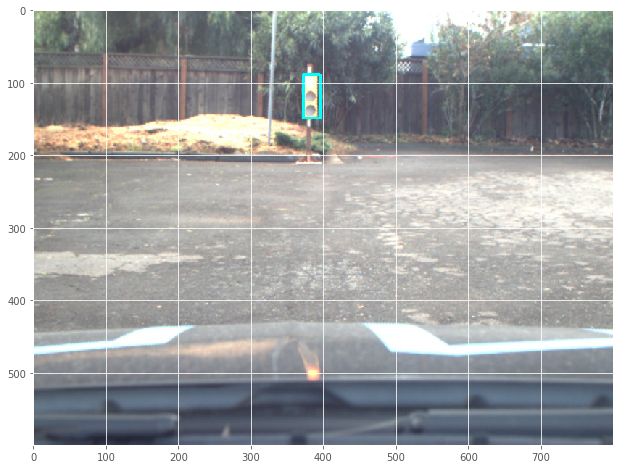

In [23]:
import cv2
# Load a sample image.
image = Image.open('./assets/left0306.jpg')
#image = Image.open('~/Qis_learning/Self_driving_engineer/Capstone/CarND-Capstone-3/imgs/trafficlights/StopLightImage_1.png')

# image = image[0:3]
image_na = np.asarray(image, dtype=np.uint8)
print('image size', image.size)
print('image_na.shape', image_na.shape)
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
print('image_np.size=', image_np.size)
with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
#     print("beforefilter boxes", boxes)
#     print("beforefilter scores", scores)
#     print("beforefilter classes", classes)
    confidence_cutoff = 0.10
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    print('width=', width)
    print('height=', height)
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)
    print('boxes =', boxes)
    print('box_coords =', box_coords)
    print('scores =', scores)
    print('classes =', classes)
    plt.figure(figsize=(12, 8))
    plt.imshow(image) 

#     print("x1=", x1)
#     img_ob = cv2.resize(image_na[x1:x2,y1:y2], (32,32))
#     plt.imshow(img_ob)



image_nb.shape= (600, 800, 3)
red_light len = 0


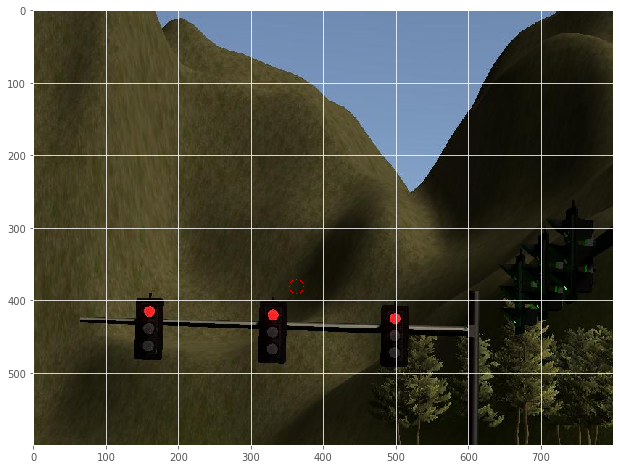

In [16]:

light_model = load_model('./assets/tl_model_5.h5')
graph = tf.get_default_graph()
red_light = []
image_nb = np.copy(image_na)
plt.figure(figsize=(12, 8))
plt.imshow(image_nb)
print('image_nb.shape=',image_nb.shape)
print('red_light len =', len(red_light))

In [7]:
for i in range(boxes.shape[0]):
    print('boxes[i]=', boxes[i])
    if classes[i] == 10:
        x1 = np.int(box_coords[i][0])
        x2 = np.int(box_coords[i][2])
        y1 = np.int(box_coords[i][1])
        y2 = np.int(box_coords[i][3])
        h = y2 - y1
        w = x2 - x1
        ratio = h/(w+0.01)
        if (h<20) or (w<20) or (ratio<0.1) or (ratio>10):
            img_light = np.zeros((1, 32, 32, 3), dtype=np.uint8)
        else:
            print('x1=', x1)
            print('x2=', x2)
            print('y1=', y1)
            print('y2=', y2)
            img_light = image_nb[x1:x2, y1:y2, :]
            print('img_light.shape=', img_light.shape)
            plt.imshow(img_light)
            img_light = cv2.resize(img_light, (32,32))
            plt.figure(figsize=(12, 8))
            plt.imshow(img_light)
            img_light = np.expand_dims(np.asarray(img_light, dtype=np.uint8), 0)
            print('expanded img_light.shape =', img_light.shape)
            red_light.append(img_light)
            print('red_light len=', len(red_light))
            

boxes[i]= [0.67602485 0.61268693 0.818791   0.64552873]
boxes[i]= [0.66703314 0.18047158 0.79335254 0.22242226]


In [ ]:

# for i in range(boxes.shape[0]):
#     if classes[i] == 10:
# #         x1 = np.uint8(boxes[i][0]*height)
# #         x2 = np.uint8(boxes[i][2]*height)
# #         y1 = np.uint8(boxes[i][1]*width)
# #         y2 = np.uint8(boxes[i][3]*width)
#         x1 = np.int(box_coords[i][0])
#         x2 = np.int(box_coords[i][2])
#         y1 = np.int(box_coords[i][1])
#         y2 = np.int(box_coords[i][3])
#         h = y2 - y1
#         w = x2 - x1
#         ratio = h/(w+0.01)
#         if (h<20) or (w<20) or (ratio<0.1) or (ratio>10):
#             img_light = np.zeros((1, 32, 32, 3), dtype=np.uint8)
#         else:
#             print('x1=', x1)
#             print('x2=', x2)
#             print('y1=', y1)
#             print('y2=', y2)
#             img_light = image_nb[x1:x2, y1:y2, :]
#             print('img_light.shape=', img_light.shape)
#             plt.imshow(img_light)
#             img_light = cv2.resize(img_light, (32,32))
#             img_light = np.expand_dims(np.asarray(img_light, dtype=np.uint8), 0)
#             print('expanded img_light.shape =', img_light.shape)
#             with graph.as_default():
#                 light_predict = light_model.predict(img_light)
#                 print('light_predict=', light_predict)
#                 light_color = light_classes.argmax(light_predict)
#             red_light.append(light_color)
#     print('red_light are', red_light)
for i in range(len(red_light)):
    with graph.as_default():
        light_predict = light_model.predict(red_light[i])
        print('light_predict =', light_predict)

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [ ]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [ ]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('output_video.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [11]:
clip = VideoFileClip('output_video.mp4')

In [26]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
    #pass
    draw_img = Image.fromarray(img)
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: np.expand_dims(img, 0)})
    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.2
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(draw_img, box_coords, classes)
    print('classes is', classes)
    return np.array(draw_img)

**[Sample solution](./exercise-solutions/e5.py)**

In [27]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result4.mp4')

classes is [2.]
[MoviePy] >>>> Building video result4.mp4
[MoviePy] Writing video result4.mp4


  0%|          | 1/2563 [00:00<04:40,  9.15it/s]

classes is [2.]


  0%|          | 2/2563 [00:00<04:38,  9.20it/s]

classes is [2.]


  0%|          | 3/2563 [00:00<04:41,  9.09it/s]

classes is [2.]


  0%|          | 4/2563 [00:00<04:42,  9.05it/s]

classes is [2.]


  0%|          | 5/2563 [00:00<04:38,  9.20it/s]

classes is [2.]


  0%|          | 6/2563 [00:00<04:34,  9.33it/s]

classes is [2.]


  0%|          | 7/2563 [00:00<04:30,  9.43it/s]

classes is [2.]


  0%|          | 8/2563 [00:00<04:28,  9.52it/s]

classes is [2.]


  0%|          | 9/2563 [00:00<04:27,  9.54it/s]

classes is [2.]


  0%|          | 10/2563 [00:01<04:26,  9.59it/s]

classes is [2.]


  0%|          | 11/2563 [00:01<04:26,  9.56it/s]

classes is [2.]


  0%|          | 12/2563 [00:01<04:24,  9.65it/s]

classes is [2.]
classes is [2.]


  1%|          | 16/2563 [00:01<04:17,  9.91it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  1%|          | 19/2563 [00:01<04:16,  9.94it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  1%|          | 21/2563 [00:02<04:12, 10.08it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  1%|          | 24/2563 [00:02<04:17,  9.84it/s]

classes is [2.]
classes is [2.]


  1%|          | 26/2563 [00:02<04:24,  9.59it/s]

classes is [2.]
classes is [2.]


  1%|          | 28/2563 [00:02<04:25,  9.55it/s]

classes is [2.]
classes is [2.]


  1%|          | 30/2563 [00:03<04:21,  9.70it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  1%|▏         | 33/2563 [00:03<04:23,  9.59it/s]

classes is [2.]
classes is [2.]


  1%|▏         | 36/2563 [00:03<04:17,  9.81it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  1%|▏         | 38/2563 [00:03<04:41,  8.96it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 40/2563 [00:04<04:47,  8.77it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 43/2563 [00:04<04:29,  9.35it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  2%|▏         | 45/2563 [00:04<04:26,  9.46it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 47/2563 [00:04<04:37,  9.07it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 48/2563 [00:05<04:38,  9.04it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  2%|▏         | 52/2563 [00:05<04:24,  9.51it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 54/2563 [00:05<04:20,  9.63it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 56/2563 [00:05<04:32,  9.21it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 58/2563 [00:06<04:28,  9.35it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 60/2563 [00:06<04:22,  9.55it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 62/2563 [00:06<04:18,  9.66it/s]

classes is [2.]
classes is [2.]


  2%|▏         | 64/2563 [00:06<04:20,  9.58it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 66/2563 [00:06<04:29,  9.27it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 68/2563 [00:07<04:37,  8.98it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 70/2563 [00:07<04:40,  8.90it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 72/2563 [00:07<04:38,  8.95it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 74/2563 [00:07<04:30,  9.20it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 76/2563 [00:08<04:27,  9.30it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 78/2563 [00:08<04:21,  9.51it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 80/2563 [00:08<04:28,  9.24it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 82/2563 [00:08<04:28,  9.23it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 84/2563 [00:08<04:35,  8.99it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 86/2563 [00:09<04:36,  8.97it/s]

classes is [2.]
classes is [2.]


  3%|▎         | 88/2563 [00:09<04:28,  9.23it/s]

classes is [2.]
classes is [2.]


  4%|▎         | 90/2563 [00:09<04:20,  9.49it/s]

classes is [2.]
classes is [2.]
classes is [2.]


  4%|▎         | 93/2563 [00:09<04:25,  9.31it/s]

classes is [2.]
classes is [2.]


  4%|▎         | 95/2563 [00:10<04:23,  9.37it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 97/2563 [00:10<04:20,  9.47it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 99/2563 [00:10<04:35,  8.94it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 101/2563 [00:10<04:44,  8.66it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 103/2563 [00:10<05:02,  8.14it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 105/2563 [00:11<04:54,  8.34it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 107/2563 [00:11<04:38,  8.83it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 109/2563 [00:11<04:33,  8.99it/s]

classes is [2.]
classes is [2.]


  4%|▍         | 111/2563 [00:11<04:32,  9.00it/s]

classes is [1.]
classes is [1.]


  4%|▍         | 113/2563 [00:12<04:21,  9.37it/s]

classes is [1.]
classes is [1.]


  4%|▍         | 115/2563 [00:12<04:18,  9.49it/s]

classes is [1.]
classes is [1.]


  5%|▍         | 117/2563 [00:12<04:15,  9.57it/s]

classes is [1.]
classes is [1.]


  5%|▍         | 119/2563 [00:12<04:14,  9.60it/s]

classes is [1.]
classes is [1.]


  5%|▍         | 121/2563 [00:12<04:20,  9.39it/s]

classes is [1.]
classes is [1.]


  5%|▍         | 123/2563 [00:13<04:24,  9.21it/s]

classes is [1.]
classes is [1.]


  5%|▍         | 125/2563 [00:13<04:21,  9.34it/s]

classes is [1.]
classes is [1.]


  5%|▍         | 127/2563 [00:13<04:26,  9.15it/s]

classes is [1.]
classes is [1.]


  5%|▌         | 129/2563 [00:13<04:32,  8.94it/s]

classes is [1.]
classes is [1.]


  5%|▌         | 131/2563 [00:14<04:30,  9.00it/s]

classes is [1.]
classes is [1.]


  5%|▌         | 133/2563 [00:14<04:34,  8.84it/s]

classes is [1.]
classes is [1.]


  5%|▌         | 135/2563 [00:14<04:32,  8.92it/s]

classes is [1.]
classes is [1.]


  5%|▌         | 137/2563 [00:14<04:25,  9.14it/s]

classes is [1.]
classes is [1.]


  5%|▌         | 139/2563 [00:14<04:24,  9.17it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 141/2563 [00:15<04:23,  9.20it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 143/2563 [00:15<04:25,  9.10it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 145/2563 [00:15<04:28,  9.00it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 147/2563 [00:15<04:27,  9.03it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 149/2563 [00:16<04:26,  9.06it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 151/2563 [00:16<04:36,  8.74it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 153/2563 [00:16<04:30,  8.91it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 155/2563 [00:16<04:26,  9.03it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 157/2563 [00:16<04:35,  8.73it/s]

classes is [1.]
classes is [1.]


  6%|▌         | 159/2563 [00:17<04:34,  8.77it/s]

classes is [1.]
classes is [1.]


  6%|▋         | 161/2563 [00:17<04:33,  8.78it/s]

classes is [1.]
classes is [1.]


  6%|▋         | 163/2563 [00:17<04:29,  8.92it/s]

classes is [1.]
classes is [1.]


  6%|▋         | 165/2563 [00:17<04:19,  9.24it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 167/2563 [00:18<04:14,  9.42it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 169/2563 [00:18<04:16,  9.33it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 171/2563 [00:18<04:11,  9.50it/s]

classes is [1.]
classes is [1.]
classes is [1.]


  7%|▋         | 174/2563 [00:18<04:25,  8.98it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 176/2563 [00:19<04:33,  8.73it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 178/2563 [00:19<04:27,  8.93it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 180/2563 [00:19<04:25,  8.98it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 182/2563 [00:19<04:22,  9.06it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 184/2563 [00:19<04:22,  9.07it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 186/2563 [00:20<04:13,  9.38it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 188/2563 [00:20<04:16,  9.24it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 190/2563 [00:20<04:14,  9.33it/s]

classes is [1.]
classes is [1.]


  7%|▋         | 192/2563 [00:20<04:26,  8.90it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 194/2563 [00:20<04:29,  8.81it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 196/2563 [00:21<04:42,  8.39it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 198/2563 [00:21<04:27,  8.86it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 200/2563 [00:21<04:21,  9.04it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 202/2563 [00:21<04:18,  9.14it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 204/2563 [00:22<04:15,  9.22it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 206/2563 [00:22<04:09,  9.44it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 208/2563 [00:22<04:10,  9.40it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 210/2563 [00:22<04:16,  9.16it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 212/2563 [00:22<04:14,  9.23it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 214/2563 [00:23<04:14,  9.24it/s]

classes is [1.]
classes is [1.]


  8%|▊         | 216/2563 [00:23<04:22,  8.94it/s]

classes is [1.]
classes is [1.]


  9%|▊         | 218/2563 [00:23<04:17,  9.10it/s]

classes is [1.]
classes is [1.]


  9%|▊         | 220/2563 [00:23<04:17,  9.11it/s]

classes is [1.]
classes is [1.]


  9%|▊         | 222/2563 [00:24<04:14,  9.21it/s]

classes is [1.]
classes is [1.]


  9%|▊         | 224/2563 [00:24<04:15,  9.16it/s]

classes is [1.]
classes is [1.]


  9%|▉         | 226/2563 [00:24<04:11,  9.30it/s]

classes is [1.]
classes is [1.]


  9%|▉         | 228/2563 [00:24<04:13,  9.23it/s]

classes is [1.]
classes is [1.]


  9%|▉         | 230/2563 [00:24<04:11,  9.27it/s]

classes is [1.]
classes is [1.]


  9%|▉         | 232/2563 [00:25<04:05,  9.50it/s]

classes is [1.]
classes is [1.]
classes is [1.]


  9%|▉         | 236/2563 [00:25<03:58,  9.77it/s]

classes is [1.]
classes is [3.]
classes is [3.]


  9%|▉         | 238/2563 [00:25<04:06,  9.43it/s]

classes is [3.]
classes is [3.]


  9%|▉         | 240/2563 [00:25<04:12,  9.22it/s]

classes is [3.]
classes is [3.]


  9%|▉         | 242/2563 [00:26<04:18,  8.98it/s]

classes is [3.]
classes is [3.]


 10%|▉         | 244/2563 [00:26<04:24,  8.76it/s]

classes is [3.]
classes is [3.]


 10%|▉         | 246/2563 [00:26<04:18,  8.96it/s]

classes is [3.]
classes is [3.]


 10%|▉         | 248/2563 [00:26<04:21,  8.85it/s]

classes is [3.]
classes is [3.]


 10%|▉         | 250/2563 [00:27<04:15,  9.04it/s]

classes is [3.]
classes is [3.]


 10%|▉         | 252/2563 [00:27<04:18,  8.92it/s]

classes is [3.]
classes is [3.]


 10%|▉         | 254/2563 [00:27<04:15,  9.02it/s]

classes is [3.]
classes is [3.]


 10%|▉         | 256/2563 [00:27<04:11,  9.18it/s]

classes is [3.]
classes is [3.]


 10%|█         | 258/2563 [00:27<04:10,  9.19it/s]

classes is [3.]
classes is [3.]


 10%|█         | 260/2563 [00:28<04:09,  9.25it/s]

classes is [3.]
classes is [3.]


 10%|█         | 262/2563 [00:28<04:11,  9.16it/s]

classes is [3.]
classes is [3. 1.]


 10%|█         | 264/2563 [00:28<04:13,  9.05it/s]

classes is [3. 1.]
classes is [3. 1.]


 10%|█         | 266/2563 [00:28<04:10,  9.17it/s]

classes is [3. 1.]
classes is [3. 1.]


 10%|█         | 268/2563 [00:29<04:15,  8.99it/s]

classes is [3.]
classes is [3.]


 11%|█         | 270/2563 [00:29<04:13,  9.03it/s]

classes is [3.]
classes is [3.]


 11%|█         | 272/2563 [00:29<04:12,  9.06it/s]

classes is [3.]
classes is [3.]


 11%|█         | 274/2563 [00:29<04:11,  9.09it/s]

classes is [3.]
classes is [3. 1.]


 11%|█         | 276/2563 [00:29<04:10,  9.14it/s]

classes is [3.]
classes is [1. 3.]


 11%|█         | 278/2563 [00:30<04:12,  9.04it/s]

classes is [3.]
classes is [3.]


 11%|█         | 280/2563 [00:30<04:22,  8.69it/s]

classes is [3.]
classes is [3.]


 11%|█         | 282/2563 [00:30<04:17,  8.85it/s]

classes is [3.]
classes is [3.]


 11%|█         | 284/2563 [00:30<04:13,  8.99it/s]

classes is [3.]
classes is [3. 1.]


 11%|█         | 286/2563 [00:31<04:11,  9.04it/s]

classes is [3.]
classes is [3.]


 11%|█         | 288/2563 [00:31<04:13,  8.97it/s]

classes is [3. 1.]
classes is [1.]


 11%|█▏        | 290/2563 [00:31<04:14,  8.95it/s]

classes is [1.]
classes is [1.]


 11%|█▏        | 292/2563 [00:31<04:10,  9.08it/s]

classes is [1.]
classes is [3.]


 11%|█▏        | 294/2563 [00:31<04:02,  9.36it/s]

classes is [3.]
classes is [3.]


 12%|█▏        | 296/2563 [00:32<04:11,  9.03it/s]

classes is [1.]
classes is [3.]


 12%|█▏        | 298/2563 [00:32<04:12,  8.98it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 300/2563 [00:32<04:10,  9.02it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 302/2563 [00:32<04:13,  8.93it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 304/2563 [00:33<04:10,  9.03it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 306/2563 [00:33<04:13,  8.91it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 308/2563 [00:33<04:05,  9.17it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 310/2563 [00:33<04:05,  9.19it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 312/2563 [00:33<04:05,  9.16it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 314/2563 [00:34<04:15,  8.80it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 316/2563 [00:34<04:12,  8.90it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 318/2563 [00:34<04:08,  9.04it/s]

classes is [2.]
classes is [2.]


 12%|█▏        | 320/2563 [00:34<04:10,  8.96it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 322/2563 [00:35<04:11,  8.91it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 324/2563 [00:35<04:08,  9.01it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 326/2563 [00:35<04:07,  9.03it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 328/2563 [00:35<04:04,  9.13it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 330/2563 [00:35<04:12,  8.85it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 332/2563 [00:36<04:07,  9.02it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 334/2563 [00:36<04:04,  9.10it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 336/2563 [00:36<04:11,  8.86it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 338/2563 [00:36<04:07,  8.98it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 340/2563 [00:37<04:17,  8.64it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 342/2563 [00:37<04:18,  8.58it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 344/2563 [00:37<04:16,  8.66it/s]

classes is [2.]
classes is [2.]


 13%|█▎        | 346/2563 [00:37<04:10,  8.86it/s]

classes is [2.]
classes is [2.]


 14%|█▎        | 348/2563 [00:37<04:04,  9.06it/s]

classes is [2.]
classes is [2.]


 14%|█▎        | 350/2563 [00:38<04:07,  8.94it/s]

classes is [2.]
classes is [2.]


 14%|█▎        | 352/2563 [00:38<04:07,  8.92it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 354/2563 [00:38<04:05,  8.98it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 356/2563 [00:38<04:03,  9.05it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 358/2563 [00:39<04:26,  8.26it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 360/2563 [00:39<04:18,  8.53it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 362/2563 [00:39<04:11,  8.75it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 364/2563 [00:39<04:06,  8.93it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 366/2563 [00:40<04:09,  8.79it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 368/2563 [00:40<04:16,  8.55it/s]

classes is [2.]
classes is [2.]


 14%|█▍        | 370/2563 [00:40<04:10,  8.76it/s]

classes is [2.]
classes is [2.]


 15%|█▍        | 372/2563 [00:40<04:06,  8.88it/s]

classes is [2.]
classes is [2.]


 15%|█▍        | 374/2563 [00:40<04:13,  8.65it/s]

classes is [2.]
classes is [2.]


 15%|█▍        | 376/2563 [00:41<04:13,  8.62it/s]

classes is [2.]
classes is [2.]


 15%|█▍        | 378/2563 [00:41<04:38,  7.84it/s]

classes is [2.]
classes is [2.]


 15%|█▍        | 380/2563 [00:41<04:30,  8.06it/s]

classes is [2.]
classes is [2.]


 15%|█▍        | 382/2563 [00:41<04:17,  8.47it/s]

classes is [2.]
classes is [2.]


 15%|█▍        | 384/2563 [00:42<04:19,  8.38it/s]

classes is [2.]
classes is [2.]


 15%|█▌        | 386/2563 [00:42<04:13,  8.60it/s]

classes is []
classes is []


 15%|█▌        | 388/2563 [00:42<04:09,  8.73it/s]

classes is []
classes is []


 15%|█▌        | 390/2563 [00:42<04:07,  8.78it/s]

classes is []
classes is []


 15%|█▌        | 392/2563 [00:43<04:04,  8.87it/s]

classes is []
classes is [2.]


 15%|█▌        | 394/2563 [00:43<04:00,  9.00it/s]

classes is [2.]
classes is [2.]


 15%|█▌        | 396/2563 [00:43<03:56,  9.18it/s]

classes is []
classes is [2.]


 16%|█▌        | 398/2563 [00:43<03:50,  9.40it/s]

classes is []
classes is []


 16%|█▌        | 400/2563 [00:43<03:53,  9.28it/s]

classes is []
classes is []


 16%|█▌        | 402/2563 [00:44<03:59,  9.04it/s]

classes is []
classes is [1.]


 16%|█▌        | 404/2563 [00:44<03:55,  9.15it/s]

classes is [1.]
classes is [1.]


 16%|█▌        | 406/2563 [00:44<03:59,  9.00it/s]

classes is [1.]
classes is [1.]


 16%|█▌        | 408/2563 [00:44<03:56,  9.12it/s]

classes is [1.]
classes is [1.]


 16%|█▌        | 410/2563 [00:45<04:03,  8.84it/s]

classes is [1.]
classes is [1.]


 16%|█▌        | 412/2563 [00:45<04:09,  8.63it/s]

classes is [1.]
classes is [1.]


 16%|█▌        | 414/2563 [00:45<04:06,  8.72it/s]

classes is [1.]
classes is [1.]


 16%|█▌        | 416/2563 [00:45<04:09,  8.62it/s]

classes is [1.]
classes is [1.]


 16%|█▋        | 418/2563 [00:45<04:08,  8.63it/s]

classes is [1.]
classes is [1.]


 16%|█▋        | 420/2563 [00:46<04:00,  8.92it/s]

classes is [1.]
classes is [1.]


 16%|█▋        | 422/2563 [00:46<03:57,  9.01it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 424/2563 [00:46<03:50,  9.29it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 426/2563 [00:46<03:45,  9.49it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 428/2563 [00:47<03:46,  9.41it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 430/2563 [00:47<03:45,  9.48it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 432/2563 [00:47<03:44,  9.48it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 434/2563 [00:47<03:47,  9.37it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 436/2563 [00:47<03:43,  9.53it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 438/2563 [00:48<03:38,  9.72it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 441/2563 [00:48<03:39,  9.69it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 17%|█▋        | 443/2563 [00:48<03:40,  9.59it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 445/2563 [00:48<03:39,  9.64it/s]

classes is [1.]
classes is [1.]


 17%|█▋        | 447/2563 [00:49<03:42,  9.52it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 449/2563 [00:49<03:41,  9.55it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 451/2563 [00:49<03:41,  9.53it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 453/2563 [00:49<03:40,  9.58it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 455/2563 [00:49<03:39,  9.60it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 457/2563 [00:50<03:41,  9.49it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 459/2563 [00:50<03:39,  9.58it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 461/2563 [00:50<03:40,  9.54it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 463/2563 [00:50<03:39,  9.56it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 465/2563 [00:50<03:38,  9.62it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 467/2563 [00:51<03:44,  9.35it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 469/2563 [00:51<03:51,  9.05it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 471/2563 [00:51<03:57,  8.82it/s]

classes is [1.]
classes is [1.]


 18%|█▊        | 473/2563 [00:51<03:49,  9.11it/s]

classes is [1.]
classes is [1.]


 19%|█▊        | 475/2563 [00:52<03:44,  9.32it/s]

classes is [1.]
classes is [1.]


 19%|█▊        | 477/2563 [00:52<03:42,  9.38it/s]

classes is [1.]
classes is [1.]


 19%|█▊        | 479/2563 [00:52<03:47,  9.17it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 481/2563 [00:52<03:41,  9.42it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 483/2563 [00:52<03:38,  9.51it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 485/2563 [00:53<03:38,  9.51it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 487/2563 [00:53<03:37,  9.55it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 489/2563 [00:53<03:37,  9.52it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 491/2563 [00:53<03:38,  9.49it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 493/2563 [00:53<03:43,  9.28it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 495/2563 [00:54<03:37,  9.50it/s]

classes is [1.]
classes is [1.]


 19%|█▉        | 497/2563 [00:54<03:36,  9.55it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 20%|█▉        | 500/2563 [00:54<03:37,  9.50it/s]

classes is [1.]
classes is [1.]


 20%|█▉        | 502/2563 [00:54<03:35,  9.55it/s]

classes is [1.]
classes is [1.]


 20%|█▉        | 504/2563 [00:55<03:34,  9.61it/s]

classes is [1.]
classes is [1.]


 20%|█▉        | 506/2563 [00:55<03:34,  9.59it/s]

classes is [1.]
classes is [1.]


 20%|█▉        | 508/2563 [00:55<03:39,  9.35it/s]

classes is [1.]
classes is [1.]


 20%|█▉        | 510/2563 [00:55<03:42,  9.22it/s]

classes is [1.]
classes is [1.]


 20%|█▉        | 512/2563 [00:55<03:39,  9.33it/s]

classes is [1.]
classes is [1.]


 20%|██        | 514/2563 [00:56<03:41,  9.24it/s]

classes is [1.]
classes is [1.]


 20%|██        | 516/2563 [00:56<03:43,  9.16it/s]

classes is [1.]
classes is [1.]


 20%|██        | 518/2563 [00:56<03:36,  9.44it/s]

classes is [1.]
classes is [1.]


 20%|██        | 520/2563 [00:56<03:34,  9.50it/s]

classes is [1.]
classes is [1.]


 20%|██        | 522/2563 [00:57<03:39,  9.32it/s]

classes is [1.]
classes is [1.]


 20%|██        | 524/2563 [00:57<03:40,  9.26it/s]

classes is [1.]
classes is [1.]


 21%|██        | 526/2563 [00:57<03:37,  9.37it/s]

classes is [1.]
classes is [1.]


 21%|██        | 528/2563 [00:57<03:35,  9.43it/s]

classes is [1.]
classes is [1.]


 21%|██        | 530/2563 [00:57<03:35,  9.42it/s]

classes is [1.]
classes is [1.]


 21%|██        | 532/2563 [00:58<03:35,  9.41it/s]

classes is [1.]
classes is [1.]


 21%|██        | 534/2563 [00:58<03:36,  9.37it/s]

classes is [1.]
classes is [1.]


 21%|██        | 536/2563 [00:58<03:34,  9.44it/s]

classes is [1.]
classes is [1.]


 21%|██        | 538/2563 [00:58<03:35,  9.42it/s]

classes is [1.]
classes is [1.]


 21%|██        | 540/2563 [00:58<03:37,  9.29it/s]

classes is [1.]
classes is [1.]


 21%|██        | 542/2563 [00:59<03:36,  9.35it/s]

classes is [1.]
classes is [1.]


 21%|██        | 544/2563 [00:59<03:37,  9.30it/s]

classes is [1. 3.]
classes is [1. 3.]


 21%|██▏       | 546/2563 [00:59<03:34,  9.41it/s]

classes is [1. 3.]
classes is [1.]


 21%|██▏       | 548/2563 [00:59<03:34,  9.39it/s]

classes is [1. 3.]
classes is [1.]


 21%|██▏       | 550/2563 [00:59<03:30,  9.56it/s]

classes is [1.]
classes is [1.]


 22%|██▏       | 552/2563 [01:00<03:32,  9.44it/s]

classes is [1.]
classes is [1.]


 22%|██▏       | 554/2563 [01:00<03:34,  9.38it/s]

classes is [1.]
classes is [1.]


 22%|██▏       | 556/2563 [01:00<03:33,  9.42it/s]

classes is [1.]
classes is [3.]


 22%|██▏       | 558/2563 [01:00<03:33,  9.41it/s]

classes is [1.]
classes is [1.]


 22%|██▏       | 560/2563 [01:01<03:32,  9.41it/s]

classes is [1.]
classes is []


 22%|██▏       | 562/2563 [01:01<03:34,  9.34it/s]

classes is [3.]
classes is [3.]


 22%|██▏       | 564/2563 [01:01<03:33,  9.38it/s]

classes is [3.]
classes is [3.]


 22%|██▏       | 566/2563 [01:01<03:34,  9.32it/s]

classes is [3.]
classes is [3.]


 22%|██▏       | 568/2563 [01:01<03:30,  9.47it/s]

classes is [3.]
classes is [1.]


 22%|██▏       | 570/2563 [01:02<03:32,  9.40it/s]

classes is [1.]
classes is [1.]


 22%|██▏       | 572/2563 [01:02<03:34,  9.29it/s]

classes is [1. 3.]
classes is [1.]


 22%|██▏       | 574/2563 [01:02<03:36,  9.20it/s]

classes is [3.]
classes is [3.]


 22%|██▏       | 576/2563 [01:02<03:32,  9.34it/s]

classes is [1.]
classes is [1.]


 23%|██▎       | 578/2563 [01:02<03:33,  9.32it/s]

classes is [1.]
classes is [1.]


 23%|██▎       | 580/2563 [01:03<03:34,  9.25it/s]

classes is [1.]
classes is []


 23%|██▎       | 582/2563 [01:03<03:36,  9.15it/s]

classes is []
classes is [3.]


 23%|██▎       | 584/2563 [01:03<03:36,  9.16it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 586/2563 [01:03<03:30,  9.40it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 588/2563 [01:04<03:29,  9.42it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 590/2563 [01:04<03:28,  9.46it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 592/2563 [01:04<03:31,  9.33it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 594/2563 [01:04<03:28,  9.42it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 596/2563 [01:04<03:34,  9.19it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 598/2563 [01:05<03:29,  9.39it/s]

classes is [3.]
classes is [3.]


 23%|██▎       | 600/2563 [01:05<03:30,  9.35it/s]

classes is [3.]
classes is []


 23%|██▎       | 602/2563 [01:05<03:28,  9.40it/s]

classes is [2.]
classes is [2.]


 24%|██▎       | 604/2563 [01:05<03:31,  9.25it/s]

classes is [2.]
classes is [2.]


 24%|██▎       | 606/2563 [01:05<03:26,  9.47it/s]

classes is [2.]
classes is [2.]


 24%|██▎       | 608/2563 [01:06<03:29,  9.33it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 610/2563 [01:06<03:26,  9.47it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 612/2563 [01:06<03:28,  9.34it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 614/2563 [01:06<03:27,  9.38it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 616/2563 [01:07<03:26,  9.44it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 618/2563 [01:07<03:26,  9.40it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 620/2563 [01:07<03:27,  9.38it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 622/2563 [01:07<03:26,  9.42it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 624/2563 [01:07<03:25,  9.46it/s]

classes is [2.]
classes is [2.]


 24%|██▍       | 626/2563 [01:08<03:26,  9.38it/s]

classes is [2.]
classes is [2.]


 25%|██▍       | 628/2563 [01:08<03:27,  9.31it/s]

classes is [2.]
classes is [2.]


 25%|██▍       | 630/2563 [01:08<03:26,  9.34it/s]

classes is [2.]
classes is [2.]


 25%|██▍       | 632/2563 [01:08<03:26,  9.34it/s]

classes is [2.]
classes is [2.]


 25%|██▍       | 634/2563 [01:08<03:24,  9.42it/s]

classes is [2.]
classes is [2.]


 25%|██▍       | 636/2563 [01:09<03:26,  9.32it/s]

classes is [2.]
classes is [2.]


 25%|██▍       | 638/2563 [01:09<03:25,  9.35it/s]

classes is [2.]
classes is [2.]


 25%|██▍       | 640/2563 [01:09<03:23,  9.44it/s]

classes is [2.]
classes is [2.]


 25%|██▌       | 642/2563 [01:09<03:28,  9.23it/s]

classes is [2.]
classes is [2.]


 25%|██▌       | 644/2563 [01:10<03:25,  9.33it/s]

classes is [2.]
classes is [2.]


 25%|██▌       | 646/2563 [01:10<03:32,  9.04it/s]

classes is [2.]
classes is [2.]


 25%|██▌       | 648/2563 [01:10<03:27,  9.25it/s]

classes is [2.]
classes is [2.]


 25%|██▌       | 650/2563 [01:10<03:26,  9.27it/s]

classes is [2.]
classes is [2.]


 25%|██▌       | 652/2563 [01:10<03:24,  9.33it/s]

classes is [2.]
classes is [2.]


 26%|██▌       | 654/2563 [01:11<03:23,  9.39it/s]

classes is []
classes is [2.]


 26%|██▌       | 656/2563 [01:11<03:23,  9.39it/s]

classes is [2.]
classes is [2.]


 26%|██▌       | 658/2563 [01:11<03:22,  9.39it/s]

classes is [2.]
classes is [2.]


 26%|██▌       | 660/2563 [01:11<03:26,  9.22it/s]

classes is [2.]
classes is [2.]


 26%|██▌       | 662/2563 [01:11<03:24,  9.31it/s]

classes is [2.]
classes is [2.]


 26%|██▌       | 664/2563 [01:12<03:25,  9.24it/s]

classes is [2.]
classes is [2.]


 26%|██▌       | 666/2563 [01:12<03:25,  9.24it/s]

classes is [2.]
classes is [2.]


 26%|██▌       | 668/2563 [01:12<03:26,  9.16it/s]

classes is [2.]
classes is []


 26%|██▌       | 670/2563 [01:12<03:27,  9.11it/s]

classes is []
classes is [2.]


 26%|██▌       | 672/2563 [01:13<03:24,  9.24it/s]

classes is [2.]
classes is [2.]


 26%|██▋       | 674/2563 [01:13<03:24,  9.25it/s]

classes is []
classes is []


 26%|██▋       | 676/2563 [01:13<03:23,  9.26it/s]

classes is [2.]
classes is [2.]


 26%|██▋       | 678/2563 [01:13<03:30,  8.95it/s]

classes is []
classes is []


 27%|██▋       | 680/2563 [01:13<03:36,  8.71it/s]

classes is []
classes is []


 27%|██▋       | 682/2563 [01:14<03:32,  8.87it/s]

classes is []
classes is []


 27%|██▋       | 684/2563 [01:14<03:24,  9.20it/s]

classes is []
classes is []


 27%|██▋       | 686/2563 [01:14<03:21,  9.33it/s]

classes is []
classes is [1.]


 27%|██▋       | 688/2563 [01:14<03:20,  9.34it/s]

classes is [1.]
classes is []


 27%|██▋       | 690/2563 [01:15<03:22,  9.25it/s]

classes is []
classes is []


 27%|██▋       | 692/2563 [01:15<03:23,  9.18it/s]

classes is []
classes is []


 27%|██▋       | 694/2563 [01:15<03:23,  9.17it/s]

classes is [1.]
classes is []


 27%|██▋       | 696/2563 [01:15<03:20,  9.29it/s]

classes is [1.]
classes is [1. 3.]


 27%|██▋       | 698/2563 [01:15<03:21,  9.27it/s]

classes is [3.]
classes is [3.]


 27%|██▋       | 700/2563 [01:16<03:23,  9.14it/s]

classes is [3.]
classes is [3.]


 27%|██▋       | 702/2563 [01:16<03:21,  9.24it/s]

classes is [3.]
classes is [3.]


 27%|██▋       | 704/2563 [01:16<03:21,  9.21it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 706/2563 [01:16<03:21,  9.24it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 708/2563 [01:17<03:26,  8.98it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 710/2563 [01:17<03:23,  9.09it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 712/2563 [01:17<03:20,  9.22it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 714/2563 [01:17<03:16,  9.39it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 716/2563 [01:17<03:16,  9.39it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 718/2563 [01:18<03:16,  9.40it/s]

classes is [3.]
classes is [3.]


 28%|██▊       | 720/2563 [01:18<03:18,  9.28it/s]

classes is [1.]
classes is []


 28%|██▊       | 722/2563 [01:18<03:17,  9.31it/s]

classes is []
classes is []


 28%|██▊       | 724/2563 [01:18<03:18,  9.28it/s]

classes is [1.]
classes is []


 28%|██▊       | 726/2563 [01:18<03:16,  9.34it/s]

classes is []
classes is []


 28%|██▊       | 728/2563 [01:19<03:17,  9.31it/s]

classes is []
classes is []


 28%|██▊       | 730/2563 [01:19<03:17,  9.29it/s]

classes is []
classes is []


 29%|██▊       | 732/2563 [01:19<03:19,  9.19it/s]

classes is []
classes is []


 29%|██▊       | 734/2563 [01:19<03:16,  9.29it/s]

classes is []
classes is []


 29%|██▊       | 736/2563 [01:20<03:16,  9.30it/s]

classes is []
classes is []


 29%|██▉       | 738/2563 [01:20<03:15,  9.32it/s]

classes is []
classes is []


 29%|██▉       | 740/2563 [01:20<03:15,  9.35it/s]

classes is []
classes is []


 29%|██▉       | 742/2563 [01:20<03:14,  9.35it/s]

classes is []
classes is [1.]


 29%|██▉       | 744/2563 [01:20<03:17,  9.20it/s]

classes is []
classes is [1.]


 29%|██▉       | 746/2563 [01:21<03:13,  9.38it/s]

classes is [1.]
classes is [1.]


 29%|██▉       | 748/2563 [01:21<03:16,  9.23it/s]

classes is [1.]
classes is [1.]


 29%|██▉       | 750/2563 [01:21<03:13,  9.39it/s]

classes is [1.]
classes is [1.]


 29%|██▉       | 752/2563 [01:21<03:16,  9.20it/s]

classes is [1.]
classes is [1.]


 29%|██▉       | 754/2563 [01:21<03:13,  9.34it/s]

classes is [1.]
classes is [1.]


 29%|██▉       | 756/2563 [01:22<03:15,  9.25it/s]

classes is [1.]
classes is [1.]


 30%|██▉       | 758/2563 [01:22<03:17,  9.13it/s]

classes is [1.]
classes is [1.]


 30%|██▉       | 760/2563 [01:22<03:17,  9.12it/s]

classes is [1.]
classes is [1.]


 30%|██▉       | 762/2563 [01:22<03:15,  9.19it/s]

classes is [1.]
classes is [1.]


 30%|██▉       | 764/2563 [01:23<03:14,  9.24it/s]

classes is [1.]
classes is [1.]


 30%|██▉       | 766/2563 [01:23<03:16,  9.13it/s]

classes is [1.]
classes is [1.]


 30%|██▉       | 768/2563 [01:23<03:18,  9.06it/s]

classes is [1.]
classes is [1.]


 30%|███       | 770/2563 [01:23<03:15,  9.19it/s]

classes is [1.]
classes is [1.]


 30%|███       | 772/2563 [01:23<03:18,  9.02it/s]

classes is [1.]
classes is [1.]


 30%|███       | 774/2563 [01:24<03:34,  8.35it/s]

classes is [1.]
classes is [1.]


 30%|███       | 776/2563 [01:24<03:36,  8.25it/s]

classes is [1.]
classes is [1.]


 30%|███       | 778/2563 [01:24<03:22,  8.83it/s]

classes is [1.]
classes is [1.]


 30%|███       | 780/2563 [01:24<03:16,  9.08it/s]

classes is [1.]
classes is [1.]


 31%|███       | 782/2563 [01:25<03:12,  9.23it/s]

classes is [1.]
classes is [1.]


 31%|███       | 784/2563 [01:25<03:12,  9.24it/s]

classes is [1.]
classes is [1.]


 31%|███       | 786/2563 [01:25<03:12,  9.25it/s]

classes is [1.]
classes is [1.]


 31%|███       | 788/2563 [01:25<03:12,  9.21it/s]

classes is [1.]
classes is [1.]


 31%|███       | 790/2563 [01:25<03:12,  9.19it/s]

classes is [1.]
classes is [1.]


 31%|███       | 792/2563 [01:26<03:14,  9.11it/s]

classes is [1.]
classes is [1.]


 31%|███       | 794/2563 [01:26<03:16,  8.98it/s]

classes is [1.]
classes is [1.]


 31%|███       | 796/2563 [01:26<03:16,  9.00it/s]

classes is [1.]
classes is [1.]


 31%|███       | 798/2563 [01:26<03:12,  9.19it/s]

classes is [1.]
classes is [1.]


 31%|███       | 800/2563 [01:27<03:08,  9.33it/s]

classes is [1.]
classes is [1.]


 31%|███▏      | 802/2563 [01:27<03:15,  9.02it/s]

classes is [1.]
classes is [1.]


 31%|███▏      | 804/2563 [01:27<03:15,  9.01it/s]

classes is [1.]
classes is [1.]


 31%|███▏      | 806/2563 [01:27<03:14,  9.03it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 808/2563 [01:27<03:10,  9.20it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 810/2563 [01:28<03:08,  9.29it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 812/2563 [01:28<03:08,  9.29it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 814/2563 [01:28<03:10,  9.16it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 816/2563 [01:28<03:11,  9.11it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 818/2563 [01:28<03:11,  9.11it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 820/2563 [01:29<03:12,  9.07it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 822/2563 [01:29<03:11,  9.10it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 824/2563 [01:29<03:11,  9.06it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 826/2563 [01:29<03:11,  9.07it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 828/2563 [01:30<03:07,  9.25it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 830/2563 [01:30<03:08,  9.20it/s]

classes is [1.]
classes is [1.]


 32%|███▏      | 832/2563 [01:30<03:07,  9.24it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 834/2563 [01:30<03:07,  9.24it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 836/2563 [01:30<03:07,  9.20it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 838/2563 [01:31<03:06,  9.23it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 840/2563 [01:31<03:09,  9.08it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 842/2563 [01:31<03:05,  9.26it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 844/2563 [01:31<03:04,  9.34it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 846/2563 [01:32<03:06,  9.22it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 848/2563 [01:32<03:08,  9.10it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 850/2563 [01:32<03:06,  9.17it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 852/2563 [01:32<03:01,  9.41it/s]

classes is [1.]
classes is [1.]


 33%|███▎      | 854/2563 [01:32<03:01,  9.40it/s]

classes is [3.]
classes is [3.]


 33%|███▎      | 856/2563 [01:33<03:00,  9.48it/s]

classes is [3. 1.]
classes is [1. 3.]


 33%|███▎      | 858/2563 [01:33<03:01,  9.38it/s]

classes is [3.]
classes is [3.]


 34%|███▎      | 860/2563 [01:33<03:03,  9.29it/s]

classes is [1.]
classes is [1. 3.]


 34%|███▎      | 862/2563 [01:33<03:03,  9.25it/s]

classes is [1. 3.]
classes is [1.]


 34%|███▎      | 864/2563 [01:33<03:04,  9.22it/s]

classes is [1.]
classes is [1.]


 34%|███▍      | 866/2563 [01:34<03:05,  9.14it/s]

classes is [1.]
classes is [1.]


 34%|███▍      | 868/2563 [01:34<03:07,  9.02it/s]

classes is [1.]
classes is [1.]


 34%|███▍      | 870/2563 [01:34<03:07,  9.04it/s]

classes is [1.]
classes is [1.]


 34%|███▍      | 872/2563 [01:34<03:08,  8.95it/s]

classes is [1.]
classes is [3.]


 34%|███▍      | 874/2563 [01:35<03:04,  9.17it/s]

classes is [3.]
classes is [3.]


 34%|███▍      | 876/2563 [01:35<03:04,  9.13it/s]

classes is [3.]
classes is [3.]


 34%|███▍      | 878/2563 [01:35<03:01,  9.28it/s]

classes is [3.]
classes is [3.]


 34%|███▍      | 880/2563 [01:35<03:02,  9.23it/s]

classes is [3.]
classes is [3.]


 34%|███▍      | 882/2563 [01:35<03:00,  9.33it/s]

classes is [1. 3.]
classes is [3.]


 34%|███▍      | 884/2563 [01:36<03:00,  9.30it/s]

classes is [1.]
classes is [1.]


 35%|███▍      | 886/2563 [01:36<03:01,  9.23it/s]

classes is [1.]
classes is [1.]


 35%|███▍      | 888/2563 [01:36<03:02,  9.19it/s]

classes is [1.]
classes is [1.]


 35%|███▍      | 890/2563 [01:36<03:00,  9.27it/s]

classes is [1.]
classes is [1.]


 35%|███▍      | 892/2563 [01:37<03:02,  9.16it/s]

classes is [1.]
classes is [1. 3.]


 35%|███▍      | 894/2563 [01:37<03:02,  9.14it/s]

classes is [3. 1.]
classes is [3. 1.]


 35%|███▍      | 896/2563 [01:37<03:01,  9.17it/s]

classes is [3.]
classes is [3.]


 35%|███▌      | 898/2563 [01:37<03:00,  9.20it/s]

classes is [3.]
classes is [3.]


 35%|███▌      | 900/2563 [01:37<03:02,  9.12it/s]

classes is [3.]
classes is [3.]


 35%|███▌      | 902/2563 [01:38<03:03,  9.07it/s]

classes is [3.]
classes is [3.]


 35%|███▌      | 904/2563 [01:38<03:01,  9.12it/s]

classes is [3.]
classes is [3.]


 35%|███▌      | 906/2563 [01:38<03:01,  9.12it/s]

classes is [3.]
classes is [3.]


 35%|███▌      | 908/2563 [01:38<02:59,  9.24it/s]

classes is [3.]
classes is [3.]


 36%|███▌      | 910/2563 [01:38<02:57,  9.29it/s]

classes is [3.]
classes is [3.]


 36%|███▌      | 912/2563 [01:39<02:57,  9.30it/s]

classes is [3.]
classes is [2.]


 36%|███▌      | 914/2563 [01:39<02:58,  9.24it/s]

classes is [2.]
classes is [2.]


 36%|███▌      | 916/2563 [01:39<02:58,  9.21it/s]

classes is [2.]
classes is [2.]


 36%|███▌      | 918/2563 [01:39<03:01,  9.04it/s]

classes is [2.]
classes is [2.]


 36%|███▌      | 920/2563 [01:40<02:58,  9.20it/s]

classes is [2.]
classes is [2.]


 36%|███▌      | 922/2563 [01:40<02:59,  9.13it/s]

classes is [2.]
classes is [2.]


 36%|███▌      | 924/2563 [01:40<02:56,  9.29it/s]

classes is [2.]
classes is [2.]


 36%|███▌      | 926/2563 [01:40<02:59,  9.12it/s]

classes is [2.]
classes is [2.]


 36%|███▌      | 928/2563 [01:40<02:56,  9.24it/s]

classes is [2.]
classes is [2.]


 36%|███▋      | 930/2563 [01:41<02:58,  9.15it/s]

classes is [2.]
classes is [2.]


 36%|███▋      | 932/2563 [01:41<02:54,  9.37it/s]

classes is [2.]
classes is [2.]


 36%|███▋      | 934/2563 [01:41<02:54,  9.34it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 936/2563 [01:41<02:53,  9.36it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 938/2563 [01:42<02:57,  9.16it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 940/2563 [01:42<02:55,  9.26it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 942/2563 [01:42<02:55,  9.26it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 944/2563 [01:42<02:51,  9.43it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 946/2563 [01:42<02:55,  9.21it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 948/2563 [01:43<02:53,  9.30it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 950/2563 [01:43<02:55,  9.18it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 952/2563 [01:43<02:50,  9.47it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 954/2563 [01:43<02:53,  9.27it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 956/2563 [01:43<02:54,  9.19it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 958/2563 [01:44<02:57,  9.03it/s]

classes is [2.]
classes is [2.]


 37%|███▋      | 960/2563 [01:44<03:07,  8.55it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 962/2563 [01:44<03:16,  8.16it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 964/2563 [01:44<03:04,  8.67it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 966/2563 [01:45<02:55,  9.08it/s]

classes is [2.]
classes is [2.]
classes is [2.]


 38%|███▊      | 969/2563 [01:45<02:48,  9.46it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 971/2563 [01:45<02:52,  9.23it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 973/2563 [01:45<02:53,  9.14it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 975/2563 [01:46<02:54,  9.10it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 977/2563 [01:46<02:56,  8.99it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 979/2563 [01:46<02:51,  9.21it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 981/2563 [01:46<02:51,  9.21it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 983/2563 [01:46<02:49,  9.33it/s]

classes is [2.]
classes is [2.]


 38%|███▊      | 985/2563 [01:47<02:49,  9.30it/s]

classes is [2.]
classes is [2.]


 39%|███▊      | 987/2563 [01:47<02:48,  9.35it/s]

classes is [2.]
classes is [2.]


 39%|███▊      | 989/2563 [01:47<02:49,  9.30it/s]

classes is [2.]
classes is [2.]


 39%|███▊      | 991/2563 [01:47<02:50,  9.21it/s]

classes is []
classes is [2.]


 39%|███▊      | 993/2563 [01:48<02:49,  9.29it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 995/2563 [01:48<02:50,  9.17it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 997/2563 [01:48<02:50,  9.21it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 999/2563 [01:48<02:48,  9.30it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 1001/2563 [01:48<02:47,  9.35it/s]

classes is [2.]
classes is []


 39%|███▉      | 1003/2563 [01:49<02:48,  9.29it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 1005/2563 [01:49<02:49,  9.21it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 1007/2563 [01:49<02:51,  9.06it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 1009/2563 [01:49<02:53,  8.97it/s]

classes is [2.]
classes is [2.]


 39%|███▉      | 1011/2563 [01:49<02:49,  9.15it/s]

classes is [2.]
classes is [2.]


 40%|███▉      | 1013/2563 [01:50<02:50,  9.06it/s]

classes is [2.]
classes is [2.]


 40%|███▉      | 1015/2563 [01:50<02:51,  9.04it/s]

classes is [2.]
classes is [2.]


 40%|███▉      | 1017/2563 [01:50<02:50,  9.05it/s]

classes is [2.]
classes is [2.]


 40%|███▉      | 1019/2563 [01:50<02:47,  9.23it/s]

classes is [2.]
classes is [2.]


 40%|███▉      | 1021/2563 [01:51<02:45,  9.30it/s]

classes is [2.]
classes is [2.]


 40%|███▉      | 1023/2563 [01:51<02:45,  9.29it/s]

classes is [2.]
classes is [3. 2.]


 40%|███▉      | 1025/2563 [01:51<02:51,  8.97it/s]

classes is [3.]
classes is [2. 3.]


 40%|████      | 1027/2563 [01:51<02:46,  9.20it/s]

classes is [3. 2.]
classes is [3.]


 40%|████      | 1029/2563 [01:51<02:43,  9.37it/s]

classes is [3.]
classes is [3.]


 40%|████      | 1031/2563 [01:52<02:41,  9.50it/s]

classes is [3.]
classes is [3.]


 40%|████      | 1033/2563 [01:52<02:42,  9.42it/s]

classes is [3.]
classes is [3.]


 40%|████      | 1035/2563 [01:52<02:39,  9.57it/s]

classes is [3.]
classes is [3.]


 40%|████      | 1037/2563 [01:52<02:40,  9.53it/s]

classes is [3.]
classes is [1.]


 41%|████      | 1039/2563 [01:53<02:40,  9.49it/s]

classes is [1.]
classes is [1.]


 41%|████      | 1041/2563 [01:53<02:38,  9.59it/s]

classes is []
classes is []


 41%|████      | 1043/2563 [01:53<02:41,  9.42it/s]

classes is []
classes is []


 41%|████      | 1045/2563 [01:53<02:40,  9.47it/s]

classes is [1.]
classes is []


 41%|████      | 1047/2563 [01:53<02:40,  9.47it/s]

classes is []
classes is []


 41%|████      | 1049/2563 [01:54<02:42,  9.30it/s]

classes is []
classes is []


 41%|████      | 1051/2563 [01:54<02:47,  9.01it/s]

classes is []
classes is []


 41%|████      | 1053/2563 [01:54<02:50,  8.86it/s]

classes is []
classes is []


 41%|████      | 1055/2563 [01:54<02:57,  8.50it/s]

classes is []
classes is []


 41%|████      | 1057/2563 [01:54<02:52,  8.74it/s]

classes is []
classes is []


 41%|████▏     | 1059/2563 [01:55<02:47,  8.97it/s]

classes is []
classes is []


 41%|████▏     | 1061/2563 [01:55<02:48,  8.94it/s]

classes is []
classes is []


 41%|████▏     | 1063/2563 [01:55<02:44,  9.12it/s]

classes is []
classes is []


 42%|████▏     | 1065/2563 [01:55<02:44,  9.12it/s]

classes is []
classes is []


 42%|████▏     | 1067/2563 [01:56<02:47,  8.93it/s]

classes is []
classes is []


 42%|████▏     | 1069/2563 [01:56<02:45,  9.03it/s]

classes is []
classes is []


 42%|████▏     | 1071/2563 [01:56<02:44,  9.10it/s]

classes is []
classes is []


 42%|████▏     | 1073/2563 [01:56<02:44,  9.05it/s]

classes is []
classes is []


 42%|████▏     | 1075/2563 [01:56<02:45,  9.00it/s]

classes is []
classes is []


 42%|████▏     | 1077/2563 [01:57<02:43,  9.06it/s]

classes is []
classes is []


 42%|████▏     | 1079/2563 [01:57<02:41,  9.22it/s]

classes is []
classes is []


 42%|████▏     | 1081/2563 [01:57<02:39,  9.27it/s]

classes is []
classes is []


 42%|████▏     | 1083/2563 [01:57<02:38,  9.35it/s]

classes is []
classes is []


 42%|████▏     | 1085/2563 [01:58<02:39,  9.26it/s]

classes is []
classes is []


 42%|████▏     | 1087/2563 [01:58<02:43,  9.01it/s]

classes is []
classes is []


 42%|████▏     | 1089/2563 [01:58<02:42,  9.05it/s]

classes is []
classes is []


 43%|████▎     | 1091/2563 [01:58<02:40,  9.17it/s]

classes is []
classes is []


 43%|████▎     | 1093/2563 [01:58<02:40,  9.15it/s]

classes is []
classes is []


 43%|████▎     | 1095/2563 [01:59<02:37,  9.30it/s]

classes is []
classes is []


 43%|████▎     | 1097/2563 [01:59<02:36,  9.36it/s]

classes is []
classes is []


 43%|████▎     | 1099/2563 [01:59<02:41,  9.08it/s]

classes is []
classes is []


 43%|████▎     | 1101/2563 [01:59<02:43,  8.95it/s]

classes is []
classes is []


 43%|████▎     | 1103/2563 [02:00<02:41,  9.02it/s]

classes is []
classes is []


 43%|████▎     | 1105/2563 [02:00<02:41,  9.03it/s]

classes is []
classes is []


 43%|████▎     | 1107/2563 [02:00<02:38,  9.20it/s]

classes is []
classes is []


 43%|████▎     | 1109/2563 [02:00<02:35,  9.37it/s]

classes is []
classes is []


 43%|████▎     | 1111/2563 [02:00<02:30,  9.62it/s]

classes is []
classes is []


 43%|████▎     | 1113/2563 [02:01<02:33,  9.45it/s]

classes is []
classes is []


 44%|████▎     | 1115/2563 [02:01<02:33,  9.41it/s]

classes is []
classes is []


 44%|████▎     | 1117/2563 [02:01<02:33,  9.43it/s]

classes is []
classes is []


 44%|████▎     | 1119/2563 [02:01<02:30,  9.61it/s]

classes is []
classes is []


 44%|████▎     | 1121/2563 [02:01<02:27,  9.75it/s]

classes is []
classes is []
classes is []


 44%|████▍     | 1123/2563 [02:02<02:26,  9.83it/s]

classes is []
classes is []
classes is []


 44%|████▍     | 1128/2563 [02:02<02:23,  9.99it/s]

classes is []
classes is []
classes is []


 44%|████▍     | 1130/2563 [02:02<02:24,  9.94it/s]

classes is []
classes is []
classes is []


 44%|████▍     | 1133/2563 [02:03<02:24,  9.90it/s]

classes is []
classes is []


 44%|████▍     | 1135/2563 [02:03<02:24,  9.88it/s]

classes is []
classes is []
classes is []


 44%|████▍     | 1138/2563 [02:03<02:25,  9.78it/s]

classes is []
classes is []


 44%|████▍     | 1140/2563 [02:03<02:25,  9.76it/s]

classes is []
classes is []


 45%|████▍     | 1142/2563 [02:04<02:25,  9.78it/s]

classes is []
classes is []


 45%|████▍     | 1144/2563 [02:04<02:26,  9.69it/s]

classes is []
classes is []


 45%|████▍     | 1146/2563 [02:04<02:24,  9.77it/s]

classes is []
classes is []
classes is []


 45%|████▍     | 1149/2563 [02:04<02:24,  9.80it/s]

classes is []
classes is []


 45%|████▍     | 1151/2563 [02:04<02:25,  9.72it/s]

classes is []
classes is []


 45%|████▍     | 1153/2563 [02:05<02:29,  9.45it/s]

classes is []
classes is []


 45%|████▌     | 1155/2563 [02:05<02:33,  9.20it/s]

classes is []
classes is []


 45%|████▌     | 1157/2563 [02:05<02:32,  9.19it/s]

classes is []
classes is []


 45%|████▌     | 1159/2563 [02:05<02:36,  8.95it/s]

classes is []
classes is []


 45%|████▌     | 1161/2563 [02:06<02:35,  9.00it/s]

classes is []
classes is []


 45%|████▌     | 1163/2563 [02:06<02:33,  9.13it/s]

classes is []
classes is []


 45%|████▌     | 1165/2563 [02:06<02:34,  9.08it/s]

classes is []
classes is []


 46%|████▌     | 1167/2563 [02:06<02:34,  9.04it/s]

classes is []
classes is [2.]


 46%|████▌     | 1169/2563 [02:06<02:33,  9.10it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1171/2563 [02:07<02:31,  9.21it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1173/2563 [02:07<02:30,  9.25it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1175/2563 [02:07<02:29,  9.26it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1177/2563 [02:07<02:28,  9.33it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1179/2563 [02:08<02:31,  9.13it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1181/2563 [02:08<02:33,  9.01it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1183/2563 [02:08<02:33,  8.99it/s]

classes is [2.]
classes is [2.]


 46%|████▌     | 1185/2563 [02:08<02:32,  9.05it/s]

classes is [2.]
classes is [2.]


 46%|████▋     | 1187/2563 [02:08<02:30,  9.16it/s]

classes is [2.]
classes is [2.]


 46%|████▋     | 1189/2563 [02:09<02:32,  9.03it/s]

classes is [1.]
classes is [1.]


 46%|████▋     | 1191/2563 [02:09<02:29,  9.20it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1193/2563 [02:09<02:27,  9.26it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1195/2563 [02:09<02:26,  9.35it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1197/2563 [02:09<02:29,  9.11it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1199/2563 [02:10<02:31,  8.98it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1201/2563 [02:10<02:28,  9.17it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1203/2563 [02:10<02:26,  9.28it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1205/2563 [02:10<02:26,  9.27it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1207/2563 [02:11<02:22,  9.50it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1209/2563 [02:11<02:22,  9.51it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1211/2563 [02:11<02:23,  9.45it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1213/2563 [02:11<02:21,  9.56it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1215/2563 [02:11<02:22,  9.46it/s]

classes is [1.]
classes is [1.]


 47%|████▋     | 1217/2563 [02:12<02:20,  9.61it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 48%|████▊     | 1221/2563 [02:12<02:16,  9.80it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 48%|████▊     | 1224/2563 [02:12<02:14,  9.93it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 48%|████▊     | 1226/2563 [02:13<02:17,  9.75it/s]

classes is [1.]
classes is [1.]


 48%|████▊     | 1228/2563 [02:13<02:15,  9.83it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 48%|████▊     | 1230/2563 [02:13<02:15,  9.83it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 48%|████▊     | 1234/2563 [02:13<02:15,  9.83it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 48%|████▊     | 1237/2563 [02:14<02:15,  9.79it/s]

classes is [1.]
classes is [1.]


 48%|████▊     | 1239/2563 [02:14<02:17,  9.63it/s]

classes is [1.]
classes is [1.]


 48%|████▊     | 1241/2563 [02:14<02:17,  9.61it/s]

classes is [1.]
classes is [1.]


 48%|████▊     | 1243/2563 [02:14<02:20,  9.39it/s]

classes is [1.]
classes is [1.]


 49%|████▊     | 1245/2563 [02:14<02:23,  9.17it/s]

classes is [1.]
classes is [1.]


 49%|████▊     | 1247/2563 [02:15<02:27,  8.90it/s]

classes is [1.]
classes is [1.]


 49%|████▊     | 1249/2563 [02:15<02:23,  9.18it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1251/2563 [02:15<02:20,  9.35it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1253/2563 [02:15<02:20,  9.35it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1255/2563 [02:16<02:18,  9.42it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1257/2563 [02:16<02:19,  9.39it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1259/2563 [02:16<02:21,  9.20it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1261/2563 [02:16<02:23,  9.06it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1263/2563 [02:16<02:21,  9.16it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1265/2563 [02:17<02:22,  9.08it/s]

classes is [1.]
classes is [1.]


 49%|████▉     | 1267/2563 [02:17<02:22,  9.10it/s]

classes is [1.]
classes is [1.]


 50%|████▉     | 1269/2563 [02:17<02:23,  9.02it/s]

classes is [1.]
classes is [1.]


 50%|████▉     | 1271/2563 [02:17<02:26,  8.83it/s]

classes is [1.]
classes is [1.]


 50%|████▉     | 1273/2563 [02:18<02:27,  8.77it/s]

classes is [1.]
classes is [1.]


 50%|████▉     | 1275/2563 [02:18<02:24,  8.89it/s]

classes is [1.]
classes is [1.]


 50%|████▉     | 1277/2563 [02:18<02:20,  9.14it/s]

classes is [1.]
classes is [1.]


 50%|████▉     | 1279/2563 [02:18<02:20,  9.13it/s]

classes is [1.]
classes is [1.]


 50%|████▉     | 1281/2563 [02:18<02:20,  9.09it/s]

classes is [1.]
classes is [1.]


 50%|█████     | 1283/2563 [02:19<02:22,  9.00it/s]

classes is [1.]
classes is [1.]


 50%|█████     | 1285/2563 [02:19<02:21,  9.05it/s]

classes is [1.]
classes is [1.]


 50%|█████     | 1287/2563 [02:19<02:19,  9.17it/s]

classes is [1.]
classes is [1.]


 50%|█████     | 1289/2563 [02:19<02:20,  9.09it/s]

classes is [1.]
classes is [1.]


 50%|█████     | 1291/2563 [02:20<02:22,  8.92it/s]

classes is [1.]
classes is [1.]


 50%|█████     | 1293/2563 [02:20<02:24,  8.81it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1295/2563 [02:20<02:23,  8.86it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1297/2563 [02:20<02:21,  8.92it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1299/2563 [02:20<02:22,  8.85it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1301/2563 [02:21<02:19,  9.05it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1303/2563 [02:21<02:19,  9.05it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1305/2563 [02:21<02:17,  9.12it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1307/2563 [02:21<02:16,  9.23it/s]

classes is [1.]
classes is [1.]


 51%|█████     | 1309/2563 [02:22<02:19,  9.01it/s]

classes is [1.]
classes is []


 51%|█████     | 1311/2563 [02:22<02:18,  9.07it/s]

classes is []
classes is []


 51%|█████     | 1313/2563 [02:22<02:16,  9.14it/s]

classes is []
classes is []


 51%|█████▏    | 1315/2563 [02:22<02:14,  9.30it/s]

classes is []
classes is []


 51%|█████▏    | 1317/2563 [02:22<02:14,  9.24it/s]

classes is []
classes is []


 51%|█████▏    | 1319/2563 [02:23<02:15,  9.20it/s]

classes is []
classes is []


 52%|█████▏    | 1321/2563 [02:23<02:15,  9.19it/s]

classes is []
classes is [1.]


 52%|█████▏    | 1323/2563 [02:23<02:17,  8.99it/s]

classes is []
classes is []


 52%|█████▏    | 1325/2563 [02:23<02:15,  9.15it/s]

classes is []
classes is []


 52%|█████▏    | 1327/2563 [02:24<02:13,  9.25it/s]

classes is []
classes is []


 52%|█████▏    | 1329/2563 [02:24<02:10,  9.45it/s]

classes is []
classes is []


 52%|█████▏    | 1331/2563 [02:24<02:11,  9.38it/s]

classes is []
classes is []


 52%|█████▏    | 1333/2563 [02:24<02:11,  9.35it/s]

classes is []
classes is []


 52%|█████▏    | 1335/2563 [02:24<02:11,  9.32it/s]

classes is []
classes is []


 52%|█████▏    | 1337/2563 [02:25<02:11,  9.32it/s]

classes is []
classes is []


 52%|█████▏    | 1339/2563 [02:25<02:23,  8.52it/s]

classes is []
classes is []


 52%|█████▏    | 1341/2563 [02:25<02:18,  8.84it/s]

classes is []
classes is []


 52%|█████▏    | 1343/2563 [02:25<02:12,  9.20it/s]

classes is []
classes is []


 52%|█████▏    | 1345/2563 [02:25<02:09,  9.44it/s]

classes is []
classes is []


 53%|█████▎    | 1347/2563 [02:26<02:05,  9.67it/s]

classes is []
classes is []


 53%|█████▎    | 1349/2563 [02:26<02:06,  9.59it/s]

classes is []
classes is []


 53%|█████▎    | 1351/2563 [02:26<02:08,  9.43it/s]

classes is []
classes is []


 53%|█████▎    | 1353/2563 [02:26<02:07,  9.48it/s]

classes is []
classes is []


 53%|█████▎    | 1355/2563 [02:27<02:08,  9.42it/s]

classes is []
classes is []


 53%|█████▎    | 1357/2563 [02:27<02:06,  9.56it/s]

classes is []
classes is []


 53%|█████▎    | 1358/2563 [02:27<02:06,  9.56it/s]

classes is []
classes is []
classes is []


 53%|█████▎    | 1362/2563 [02:27<02:04,  9.66it/s]

classes is []
classes is []


 53%|█████▎    | 1364/2563 [02:27<02:09,  9.29it/s]

classes is []
classes is []


 53%|█████▎    | 1366/2563 [02:28<02:09,  9.21it/s]

classes is []
classes is []


 53%|█████▎    | 1368/2563 [02:28<02:11,  9.09it/s]

classes is []
classes is []


 53%|█████▎    | 1370/2563 [02:28<02:11,  9.10it/s]

classes is []
classes is []


 54%|█████▎    | 1372/2563 [02:28<02:08,  9.24it/s]

classes is []
classes is []


 54%|█████▎    | 1374/2563 [02:29<02:10,  9.14it/s]

classes is []
classes is []


 54%|█████▎    | 1376/2563 [02:29<02:13,  8.92it/s]

classes is []
classes is []


 54%|█████▍    | 1378/2563 [02:29<02:13,  8.90it/s]

classes is []
classes is []


 54%|█████▍    | 1380/2563 [02:29<02:12,  8.93it/s]

classes is []
classes is []


 54%|█████▍    | 1382/2563 [02:29<02:11,  9.01it/s]

classes is []
classes is []


 54%|█████▍    | 1384/2563 [02:30<02:08,  9.14it/s]

classes is []
classes is []


 54%|█████▍    | 1386/2563 [02:30<02:06,  9.27it/s]

classes is []
classes is [1.]


 54%|█████▍    | 1388/2563 [02:30<02:06,  9.32it/s]

classes is [1.]
classes is [3.]


 54%|█████▍    | 1390/2563 [02:30<02:06,  9.28it/s]

classes is [3.]
classes is []


 54%|█████▍    | 1392/2563 [02:31<02:06,  9.23it/s]

classes is [1.]
classes is []


 54%|█████▍    | 1394/2563 [02:31<02:07,  9.13it/s]

classes is [1.]
classes is [1.]


 54%|█████▍    | 1396/2563 [02:31<02:07,  9.15it/s]

classes is []
classes is [1.]


 55%|█████▍    | 1398/2563 [02:31<02:06,  9.22it/s]

classes is []
classes is [2.]


 55%|█████▍    | 1400/2563 [02:31<02:08,  9.07it/s]

classes is [1.]
classes is [2.]


 55%|█████▍    | 1402/2563 [02:32<02:09,  8.99it/s]

classes is [2.]
classes is [1.]


 55%|█████▍    | 1404/2563 [02:32<02:06,  9.14it/s]

classes is [1.]
classes is [1.]


 55%|█████▍    | 1406/2563 [02:32<02:07,  9.06it/s]

classes is [2.]
classes is [2.]


 55%|█████▍    | 1408/2563 [02:32<02:06,  9.13it/s]

classes is [2.]
classes is [1.]


 55%|█████▌    | 1410/2563 [02:33<02:07,  9.03it/s]

classes is [2. 1.]
classes is [2.]


 55%|█████▌    | 1412/2563 [02:33<02:10,  8.82it/s]

classes is [2.]
classes is [2.]


 55%|█████▌    | 1414/2563 [02:33<02:09,  8.88it/s]

classes is [2.]
classes is [2.]


 55%|█████▌    | 1416/2563 [02:33<02:07,  9.01it/s]

classes is [2.]
classes is [2.]


 55%|█████▌    | 1418/2563 [02:33<02:06,  9.08it/s]

classes is [2.]
classes is [2.]


 55%|█████▌    | 1420/2563 [02:34<02:05,  9.09it/s]

classes is [2.]
classes is [2.]


 55%|█████▌    | 1422/2563 [02:34<02:05,  9.09it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1424/2563 [02:34<02:05,  9.09it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1426/2563 [02:34<02:06,  9.00it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1428/2563 [02:35<02:06,  9.00it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1430/2563 [02:35<02:04,  9.11it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1432/2563 [02:35<02:04,  9.09it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1434/2563 [02:35<02:04,  9.07it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1436/2563 [02:35<02:02,  9.20it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1438/2563 [02:36<02:02,  9.16it/s]

classes is [2.]
classes is [2.]


 56%|█████▌    | 1440/2563 [02:36<02:03,  9.07it/s]

classes is [2.]
classes is [2.]


 56%|█████▋    | 1442/2563 [02:36<02:02,  9.15it/s]

classes is [2.]
classes is [2.]


 56%|█████▋    | 1444/2563 [02:36<01:58,  9.46it/s]

classes is [2.]
classes is [2.]


 56%|█████▋    | 1446/2563 [02:36<01:56,  9.57it/s]

classes is [2.]
classes is [2.]


 56%|█████▋    | 1448/2563 [02:37<01:58,  9.45it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1450/2563 [02:37<01:59,  9.34it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1452/2563 [02:37<01:58,  9.41it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1454/2563 [02:37<01:57,  9.43it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1456/2563 [02:38<01:56,  9.48it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1458/2563 [02:38<01:55,  9.53it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1460/2563 [02:38<01:56,  9.49it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1462/2563 [02:38<01:55,  9.53it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1464/2563 [02:38<01:53,  9.67it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1466/2563 [02:39<01:53,  9.64it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1468/2563 [02:39<01:53,  9.63it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1470/2563 [02:39<01:54,  9.51it/s]

classes is [2.]
classes is [2.]


 57%|█████▋    | 1472/2563 [02:39<01:53,  9.62it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1474/2563 [02:39<01:52,  9.66it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1477/2563 [02:40<01:53,  9.60it/s]

classes is [2.]
classes is [2.]
classes is [2. 2.]


 58%|█████▊    | 1479/2563 [02:40<01:53,  9.56it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1481/2563 [02:40<01:53,  9.50it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1483/2563 [02:40<01:52,  9.56it/s]

classes is [2. 2.]
classes is [2. 2.]


 58%|█████▊    | 1485/2563 [02:41<01:56,  9.26it/s]

classes is [2. 2.]
classes is [2. 2.]


 58%|█████▊    | 1487/2563 [02:41<01:58,  9.07it/s]

classes is [2. 2.]
classes is [2.]


 58%|█████▊    | 1489/2563 [02:41<01:58,  9.06it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1491/2563 [02:41<01:57,  9.13it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1493/2563 [02:41<01:56,  9.17it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1495/2563 [02:42<01:59,  8.91it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1497/2563 [02:42<02:01,  8.76it/s]

classes is [2.]
classes is [2.]


 58%|█████▊    | 1499/2563 [02:42<01:56,  9.12it/s]

classes is [1.]
classes is [1.]


 59%|█████▊    | 1501/2563 [02:42<01:59,  8.92it/s]

classes is [1.]
classes is [1.]


 59%|█████▊    | 1503/2563 [02:43<02:01,  8.74it/s]

classes is [1.]
classes is [1.]


 59%|█████▊    | 1505/2563 [02:43<02:03,  8.58it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1507/2563 [02:43<01:58,  8.92it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1509/2563 [02:43<01:56,  9.01it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1511/2563 [02:43<01:54,  9.17it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1513/2563 [02:44<02:00,  8.70it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1515/2563 [02:44<02:04,  8.41it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1517/2563 [02:44<02:10,  8.05it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1519/2563 [02:44<02:01,  8.58it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1521/2563 [02:45<01:58,  8.81it/s]

classes is [1.]
classes is [1.]


 59%|█████▉    | 1523/2563 [02:45<01:56,  8.92it/s]

classes is [1.]
classes is [1.]


 60%|█████▉    | 1525/2563 [02:45<01:56,  8.88it/s]

classes is [1.]
classes is [1.]


 60%|█████▉    | 1527/2563 [02:45<01:54,  9.01it/s]

classes is [1.]
classes is [1.]


 60%|█████▉    | 1529/2563 [02:46<01:53,  9.10it/s]

classes is [1.]
classes is [1.]


 60%|█████▉    | 1531/2563 [02:46<01:53,  9.09it/s]

classes is [1.]
classes is [1.]


 60%|█████▉    | 1533/2563 [02:46<01:51,  9.23it/s]

classes is [1.]
classes is [1.]


 60%|█████▉    | 1535/2563 [02:46<01:49,  9.39it/s]

classes is [1.]
classes is [1.]


 60%|█████▉    | 1537/2563 [02:46<01:50,  9.30it/s]

classes is [1.]
classes is [1.]


 60%|██████    | 1539/2563 [02:47<01:50,  9.28it/s]

classes is [1.]
classes is [1.]


 60%|██████    | 1541/2563 [02:47<01:52,  9.10it/s]

classes is [1.]
classes is [1.]


 60%|██████    | 1543/2563 [02:47<01:51,  9.15it/s]

classes is [1.]
classes is [1.]


 60%|██████    | 1545/2563 [02:47<01:51,  9.10it/s]

classes is [1.]
classes is [1.]


 60%|██████    | 1547/2563 [02:47<01:52,  9.02it/s]

classes is [1.]
classes is [1.]


 60%|██████    | 1549/2563 [02:48<01:51,  9.10it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1551/2563 [02:48<01:51,  9.05it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1553/2563 [02:48<01:52,  9.01it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1555/2563 [02:48<01:50,  9.13it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1557/2563 [02:49<01:49,  9.19it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1559/2563 [02:49<01:51,  8.96it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1561/2563 [02:49<01:50,  9.10it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1563/2563 [02:49<01:48,  9.25it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1565/2563 [02:49<01:47,  9.30it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1567/2563 [02:50<01:46,  9.35it/s]

classes is [1.]
classes is [1.]


 61%|██████    | 1569/2563 [02:50<01:43,  9.60it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 61%|██████▏   | 1572/2563 [02:50<01:42,  9.67it/s]

classes is [1.]
classes is [1.]


 61%|██████▏   | 1574/2563 [02:50<01:43,  9.58it/s]

classes is [1.]
classes is [1.]


 61%|██████▏   | 1576/2563 [02:51<01:43,  9.54it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1578/2563 [02:51<01:42,  9.63it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1580/2563 [02:51<01:41,  9.64it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1582/2563 [02:51<01:41,  9.66it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1584/2563 [02:51<01:40,  9.71it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1586/2563 [02:52<01:41,  9.60it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 62%|██████▏   | 1589/2563 [02:52<01:45,  9.27it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1591/2563 [02:52<01:42,  9.45it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1593/2563 [02:52<01:40,  9.61it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1595/2563 [02:53<01:39,  9.72it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1597/2563 [02:53<01:40,  9.65it/s]

classes is [1.]
classes is [1.]


 62%|██████▏   | 1598/2563 [02:53<01:39,  9.65it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 63%|██████▎   | 1602/2563 [02:53<01:40,  9.54it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1604/2563 [02:54<01:41,  9.46it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1606/2563 [02:54<01:42,  9.36it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1608/2563 [02:54<01:41,  9.45it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1610/2563 [02:54<01:41,  9.36it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1612/2563 [02:54<01:41,  9.41it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1614/2563 [02:55<01:39,  9.51it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1616/2563 [02:55<01:41,  9.33it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1618/2563 [02:55<01:42,  9.23it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1620/2563 [02:55<01:40,  9.34it/s]

classes is [1.]
classes is [1.]


 63%|██████▎   | 1622/2563 [02:55<01:40,  9.35it/s]

classes is [3. 1.]
classes is [3.]


 63%|██████▎   | 1624/2563 [02:56<01:40,  9.31it/s]

classes is [3.]
classes is [3.]


 63%|██████▎   | 1626/2563 [02:56<01:39,  9.38it/s]

classes is [3.]
classes is [3.]


 64%|██████▎   | 1628/2563 [02:56<01:41,  9.22it/s]

classes is [3.]
classes is [3.]


 64%|██████▎   | 1630/2563 [02:56<01:42,  9.14it/s]

classes is [3.]
classes is [3.]


 64%|██████▎   | 1632/2563 [02:57<01:42,  9.06it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1634/2563 [02:57<01:44,  8.93it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1636/2563 [02:57<01:44,  8.87it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1638/2563 [02:57<01:44,  8.89it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1640/2563 [02:57<01:44,  8.79it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1642/2563 [02:58<01:43,  8.90it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1644/2563 [02:58<01:43,  8.90it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1646/2563 [02:58<01:42,  8.94it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1648/2563 [02:58<01:41,  9.05it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1650/2563 [02:59<01:41,  9.01it/s]

classes is [3.]
classes is [3.]


 64%|██████▍   | 1652/2563 [02:59<01:39,  9.14it/s]

classes is [3.]
classes is [3.]


 65%|██████▍   | 1654/2563 [02:59<01:41,  8.95it/s]

classes is [3.]
classes is [3.]


 65%|██████▍   | 1656/2563 [02:59<01:43,  8.74it/s]

classes is [3.]
classes is [3.]


 65%|██████▍   | 1658/2563 [02:59<01:41,  8.93it/s]

classes is [3.]
classes is [3.]


 65%|██████▍   | 1660/2563 [03:00<01:40,  8.99it/s]

classes is [3.]
classes is [3.]


 65%|██████▍   | 1662/2563 [03:00<01:38,  9.16it/s]

classes is [3.]
classes is [3.]


 65%|██████▍   | 1664/2563 [03:00<01:41,  8.84it/s]

classes is [3.]
classes is [3.]


 65%|██████▌   | 1666/2563 [03:00<01:39,  9.04it/s]

classes is [3.]
classes is [3.]


 65%|██████▌   | 1668/2563 [03:01<01:39,  8.98it/s]

classes is [3.]
classes is []


 65%|██████▌   | 1670/2563 [03:01<01:38,  9.04it/s]

classes is [3.]
classes is [3.]


 65%|██████▌   | 1672/2563 [03:01<01:38,  9.02it/s]

classes is [3.]
classes is [1. 3.]


 65%|██████▌   | 1674/2563 [03:01<01:38,  9.04it/s]

classes is [3.]
classes is [3.]


 65%|██████▌   | 1676/2563 [03:01<01:38,  9.04it/s]

classes is [3.]
classes is [3.]


 65%|██████▌   | 1678/2563 [03:02<01:39,  8.89it/s]

classes is [1.]
classes is [3.]


 66%|██████▌   | 1680/2563 [03:02<01:35,  9.21it/s]

classes is [3.]
classes is [1.]


 66%|██████▌   | 1682/2563 [03:02<01:33,  9.41it/s]

classes is [3.]
classes is [3.]


 66%|██████▌   | 1684/2563 [03:02<01:31,  9.56it/s]

classes is [1. 3.]
classes is [2.]


 66%|██████▌   | 1686/2563 [03:02<01:31,  9.63it/s]

classes is [2.]
classes is [2.]


 66%|██████▌   | 1688/2563 [03:03<01:31,  9.60it/s]

classes is [2.]
classes is [2.]


 66%|██████▌   | 1691/2563 [03:03<01:30,  9.68it/s]

classes is [2.]
classes is [2.]
classes is [2.]


 66%|██████▌   | 1693/2563 [03:03<01:30,  9.62it/s]

classes is [2.]
classes is [2.]


 66%|██████▌   | 1695/2563 [03:03<01:32,  9.40it/s]

classes is [2.]
classes is [2.]


 66%|██████▌   | 1697/2563 [03:04<01:30,  9.54it/s]

classes is [2.]
classes is [2.]


 66%|██████▋   | 1699/2563 [03:04<01:31,  9.46it/s]

classes is [2.]
classes is [2.]


 66%|██████▋   | 1701/2563 [03:04<01:32,  9.28it/s]

classes is [2.]
classes is [2.]


 66%|██████▋   | 1703/2563 [03:04<01:39,  8.68it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1705/2563 [03:05<01:40,  8.50it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1707/2563 [03:05<01:35,  9.00it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1709/2563 [03:05<01:31,  9.34it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1711/2563 [03:05<01:28,  9.59it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1713/2563 [03:05<01:27,  9.69it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1715/2563 [03:06<01:32,  9.19it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1717/2563 [03:06<01:30,  9.33it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1719/2563 [03:06<01:28,  9.49it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1721/2563 [03:06<01:30,  9.29it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1723/2563 [03:06<01:29,  9.36it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1725/2563 [03:07<01:29,  9.36it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1727/2563 [03:07<01:28,  9.45it/s]

classes is [2.]
classes is [2.]


 67%|██████▋   | 1729/2563 [03:07<01:28,  9.43it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1731/2563 [03:07<01:29,  9.30it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1733/2563 [03:08<01:29,  9.27it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1735/2563 [03:08<01:31,  9.01it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1737/2563 [03:08<01:31,  9.02it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1739/2563 [03:08<01:31,  9.03it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1741/2563 [03:08<01:30,  9.12it/s]

classes is [2. 1.]
classes is [2.]


 68%|██████▊   | 1743/2563 [03:09<01:30,  9.05it/s]

classes is [2. 1.]
classes is [2. 1.]


 68%|██████▊   | 1745/2563 [03:09<01:30,  9.02it/s]

classes is [2.]
classes is [2. 1.]


 68%|██████▊   | 1747/2563 [03:09<01:30,  8.98it/s]

classes is [2. 1.]
classes is [2. 1.]


 68%|██████▊   | 1749/2563 [03:09<01:31,  8.88it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1751/2563 [03:10<01:30,  8.98it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1753/2563 [03:10<01:29,  9.09it/s]

classes is [2.]
classes is [2.]


 68%|██████▊   | 1755/2563 [03:10<01:28,  9.09it/s]

classes is [2.]
classes is [2.]


 69%|██████▊   | 1757/2563 [03:10<01:27,  9.18it/s]

classes is [2.]
classes is [2.]


 69%|██████▊   | 1759/2563 [03:10<01:25,  9.35it/s]

classes is [2.]
classes is [2.]


 69%|██████▊   | 1761/2563 [03:11<01:27,  9.14it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1763/2563 [03:11<01:27,  9.14it/s]

classes is [2. 1.]
classes is [2.]


 69%|██████▉   | 1765/2563 [03:11<01:27,  9.07it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1767/2563 [03:11<01:27,  9.12it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1769/2563 [03:11<01:26,  9.14it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1771/2563 [03:12<01:27,  9.02it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1773/2563 [03:12<01:26,  9.13it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1775/2563 [03:12<01:29,  8.81it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1777/2563 [03:12<01:25,  9.16it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1779/2563 [03:13<01:25,  9.14it/s]

classes is [2.]
classes is [2.]


 69%|██████▉   | 1781/2563 [03:13<01:24,  9.25it/s]

classes is [2.]
classes is [2.]


 70%|██████▉   | 1783/2563 [03:13<01:23,  9.30it/s]

classes is [2.]
classes is [2.]


 70%|██████▉   | 1785/2563 [03:13<01:24,  9.19it/s]

classes is [2.]
classes is [2.]


 70%|██████▉   | 1787/2563 [03:13<01:24,  9.18it/s]

classes is [2.]
classes is [2.]


 70%|██████▉   | 1789/2563 [03:14<01:22,  9.43it/s]

classes is [2.]
classes is [2.]


 70%|██████▉   | 1792/2563 [03:14<01:19,  9.71it/s]

classes is [2.]
classes is [2.]
classes is [2.]


 70%|██████▉   | 1794/2563 [03:14<01:23,  9.22it/s]

classes is [2.]
classes is [2.]


 70%|███████   | 1796/2563 [03:14<01:25,  8.99it/s]

classes is [2.]
classes is [2.]


 70%|███████   | 1798/2563 [03:15<01:31,  8.39it/s]

classes is [2.]
classes is [2.]


 70%|███████   | 1800/2563 [03:15<01:24,  9.05it/s]

classes is [2.]
classes is [2.]
classes is [2.]


 70%|███████   | 1803/2563 [03:15<01:20,  9.40it/s]

classes is [2.]
classes is [2.]


 70%|███████   | 1805/2563 [03:15<01:19,  9.50it/s]

classes is [2.]
classes is [2.]


 71%|███████   | 1807/2563 [03:16<01:18,  9.63it/s]

classes is [2.]
classes is [1.]


 71%|███████   | 1809/2563 [03:16<01:18,  9.59it/s]

classes is [1.]
classes is [1.]


 71%|███████   | 1812/2563 [03:16<01:18,  9.54it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 71%|███████   | 1814/2563 [03:16<01:18,  9.54it/s]

classes is [1.]
classes is [1.]


 71%|███████   | 1816/2563 [03:17<01:18,  9.50it/s]

classes is [1.]
classes is [1.]


 71%|███████   | 1818/2563 [03:17<01:18,  9.55it/s]

classes is [1.]
classes is [1.]


 71%|███████   | 1820/2563 [03:17<01:17,  9.58it/s]

classes is [1.]
classes is [1.]


 71%|███████   | 1822/2563 [03:17<01:16,  9.69it/s]

classes is [1.]
classes is [1.]


 71%|███████   | 1824/2563 [03:17<01:17,  9.54it/s]

classes is [1.]
classes is [1.]


 71%|███████   | 1826/2563 [03:18<01:17,  9.53it/s]

classes is [1.]
classes is [1.]


 71%|███████▏  | 1828/2563 [03:18<01:17,  9.50it/s]

classes is [1.]
classes is [1.]


 71%|███████▏  | 1830/2563 [03:18<01:15,  9.70it/s]

classes is [1.]
classes is [1.]


 71%|███████▏  | 1832/2563 [03:18<01:16,  9.56it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1834/2563 [03:18<01:16,  9.56it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 72%|███████▏  | 1837/2563 [03:19<01:14,  9.72it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1839/2563 [03:19<01:15,  9.64it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1841/2563 [03:19<01:16,  9.42it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1843/2563 [03:19<01:17,  9.28it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1845/2563 [03:20<01:18,  9.16it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1847/2563 [03:20<01:19,  9.00it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1849/2563 [03:20<01:19,  8.99it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1851/2563 [03:20<01:17,  9.17it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1853/2563 [03:20<01:19,  8.98it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1855/2563 [03:21<01:18,  8.97it/s]

classes is [1.]
classes is [1.]


 72%|███████▏  | 1857/2563 [03:21<01:20,  8.79it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1859/2563 [03:21<01:18,  8.95it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1861/2563 [03:21<01:19,  8.85it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1863/2563 [03:22<01:18,  8.95it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1865/2563 [03:22<01:19,  8.83it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1867/2563 [03:22<01:16,  9.10it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1869/2563 [03:22<01:18,  8.90it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1871/2563 [03:23<01:17,  8.95it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1873/2563 [03:23<01:14,  9.22it/s]

classes is [1.]
classes is []


 73%|███████▎  | 1875/2563 [03:23<01:15,  9.13it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1877/2563 [03:23<01:14,  9.22it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1879/2563 [03:23<01:13,  9.29it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1881/2563 [03:24<01:16,  8.97it/s]

classes is [1.]
classes is [1.]


 73%|███████▎  | 1883/2563 [03:24<01:16,  8.92it/s]

classes is [1.]
classes is [1.]


 74%|███████▎  | 1885/2563 [03:24<01:16,  8.91it/s]

classes is []
classes is []


 74%|███████▎  | 1887/2563 [03:24<01:15,  8.98it/s]

classes is []
classes is []


 74%|███████▎  | 1889/2563 [03:24<01:14,  9.05it/s]

classes is []
classes is []


 74%|███████▍  | 1891/2563 [03:25<01:14,  9.03it/s]

classes is []
classes is []


 74%|███████▍  | 1893/2563 [03:25<01:14,  9.00it/s]

classes is []
classes is []


 74%|███████▍  | 1895/2563 [03:25<01:12,  9.18it/s]

classes is []
classes is []


 74%|███████▍  | 1897/2563 [03:25<01:12,  9.14it/s]

classes is []
classes is []


 74%|███████▍  | 1899/2563 [03:26<01:12,  9.17it/s]

classes is []
classes is []


 74%|███████▍  | 1901/2563 [03:26<01:13,  9.05it/s]

classes is []
classes is []


 74%|███████▍  | 1903/2563 [03:26<01:12,  9.09it/s]

classes is []
classes is []


 74%|███████▍  | 1905/2563 [03:26<01:10,  9.34it/s]

classes is []
classes is []


 74%|███████▍  | 1907/2563 [03:26<01:09,  9.43it/s]

classes is []
classes is []


 74%|███████▍  | 1909/2563 [03:27<01:08,  9.50it/s]

classes is []
classes is []


 75%|███████▍  | 1911/2563 [03:27<01:08,  9.53it/s]

classes is []
classes is []


 75%|███████▍  | 1913/2563 [03:27<01:07,  9.61it/s]

classes is []
classes is []


 75%|███████▍  | 1915/2563 [03:27<01:07,  9.64it/s]

classes is []
classes is []


 75%|███████▍  | 1917/2563 [03:27<01:08,  9.49it/s]

classes is []
classes is []


 75%|███████▍  | 1919/2563 [03:28<01:07,  9.57it/s]

classes is []
classes is []
classes is []


 75%|███████▍  | 1922/2563 [03:28<01:07,  9.54it/s]

classes is []
classes is []


 75%|███████▌  | 1924/2563 [03:28<01:06,  9.63it/s]

classes is []
classes is []
classes is []


 75%|███████▌  | 1927/2563 [03:29<01:05,  9.67it/s]

classes is []
classes is []


 75%|███████▌  | 1929/2563 [03:29<01:06,  9.56it/s]

classes is []
classes is []


 75%|███████▌  | 1931/2563 [03:29<01:06,  9.45it/s]

classes is []
classes is []


 75%|███████▌  | 1933/2563 [03:29<01:06,  9.47it/s]

classes is []
classes is []


 75%|███████▌  | 1935/2563 [03:29<01:07,  9.35it/s]

classes is []
classes is []


 76%|███████▌  | 1937/2563 [03:30<01:05,  9.59it/s]

classes is []
classes is []


 76%|███████▌  | 1939/2563 [03:30<01:05,  9.53it/s]

classes is []
classes is []


 76%|███████▌  | 1941/2563 [03:30<01:06,  9.38it/s]

classes is []
classes is []


 76%|███████▌  | 1943/2563 [03:30<01:06,  9.35it/s]

classes is []
classes is []


 76%|███████▌  | 1945/2563 [03:30<01:05,  9.40it/s]

classes is []
classes is []


 76%|███████▌  | 1947/2563 [03:31<01:04,  9.50it/s]

classes is []
classes is []


 76%|███████▌  | 1949/2563 [03:31<01:05,  9.33it/s]

classes is []
classes is []


 76%|███████▌  | 1951/2563 [03:31<01:07,  9.09it/s]

classes is []
classes is []


 76%|███████▌  | 1953/2563 [03:31<01:06,  9.17it/s]

classes is []
classes is []


 76%|███████▋  | 1955/2563 [03:32<01:06,  9.09it/s]

classes is []
classes is []


 76%|███████▋  | 1957/2563 [03:32<01:05,  9.20it/s]

classes is []
classes is [3.]


 76%|███████▋  | 1959/2563 [03:32<01:06,  9.04it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1961/2563 [03:32<01:06,  9.12it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1963/2563 [03:32<01:06,  8.96it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1965/2563 [03:33<01:05,  9.09it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1967/2563 [03:33<01:05,  9.12it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1969/2563 [03:33<01:06,  8.94it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1971/2563 [03:33<01:04,  9.20it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1973/2563 [03:33<01:04,  9.21it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1975/2563 [03:34<01:05,  9.03it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1977/2563 [03:34<01:04,  9.04it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1979/2563 [03:34<01:04,  9.01it/s]

classes is []
classes is [3.]


 77%|███████▋  | 1981/2563 [03:34<01:06,  8.75it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1983/2563 [03:35<01:05,  8.82it/s]

classes is [3.]
classes is [3.]


 77%|███████▋  | 1985/2563 [03:35<01:08,  8.47it/s]

classes is [3.]
classes is [3.]


 78%|███████▊  | 1987/2563 [03:35<01:10,  8.18it/s]

classes is [3.]
classes is [3.]


 78%|███████▊  | 1989/2563 [03:35<01:08,  8.43it/s]

classes is [3.]
classes is [3.]


 78%|███████▊  | 1991/2563 [03:36<01:06,  8.65it/s]

classes is [3.]
classes is [3.]


 78%|███████▊  | 1993/2563 [03:36<01:04,  8.84it/s]

classes is [3.]
classes is [3.]


 78%|███████▊  | 1995/2563 [03:36<01:02,  9.15it/s]

classes is [3.]
classes is [2.]


 78%|███████▊  | 1997/2563 [03:36<01:01,  9.16it/s]

classes is [2.]
classes is [1.]


 78%|███████▊  | 1999/2563 [03:36<01:02,  9.01it/s]

classes is [2.]
classes is [1. 2.]


 78%|███████▊  | 2001/2563 [03:37<01:03,  8.91it/s]

classes is [2.]
classes is [2.]


 78%|███████▊  | 2003/2563 [03:37<01:01,  9.10it/s]

classes is [2.]
classes is [2.]


 78%|███████▊  | 2005/2563 [03:37<01:01,  9.14it/s]

classes is [2.]
classes is [2.]


 78%|███████▊  | 2007/2563 [03:37<01:00,  9.19it/s]

classes is [2.]
classes is [2.]


 78%|███████▊  | 2009/2563 [03:38<00:58,  9.42it/s]

classes is [2.]
classes is [2.]


 78%|███████▊  | 2011/2563 [03:38<00:57,  9.58it/s]

classes is [2.]
classes is [2.]


 79%|███████▊  | 2013/2563 [03:38<00:58,  9.37it/s]

classes is [2.]
classes is [2.]


 79%|███████▊  | 2015/2563 [03:38<00:58,  9.42it/s]

classes is [2.]
classes is [2.]


 79%|███████▊  | 2017/2563 [03:38<00:58,  9.31it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2019/2563 [03:39<00:57,  9.48it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2021/2563 [03:39<00:56,  9.66it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2023/2563 [03:39<00:56,  9.60it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2025/2563 [03:39<00:55,  9.66it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2027/2563 [03:39<00:57,  9.36it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2029/2563 [03:40<00:55,  9.59it/s]

classes is [2.]
classes is [2.]
classes is [2.]


 79%|███████▉  | 2032/2563 [03:40<00:54,  9.71it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2034/2563 [03:40<00:54,  9.69it/s]

classes is [2.]
classes is [2.]


 79%|███████▉  | 2036/2563 [03:40<00:55,  9.52it/s]

classes is [2.]
classes is [2.]


 80%|███████▉  | 2038/2563 [03:41<00:54,  9.59it/s]

classes is [2.]
classes is [2.]


 80%|███████▉  | 2040/2563 [03:41<00:54,  9.52it/s]

classes is [2.]
classes is [2.]


 80%|███████▉  | 2042/2563 [03:41<00:54,  9.64it/s]

classes is [2.]
classes is [2.]


 80%|███████▉  | 2044/2563 [03:41<00:54,  9.56it/s]

classes is [2. 3.]
classes is [2.]


 80%|███████▉  | 2046/2563 [03:41<00:53,  9.66it/s]

classes is [2.]
classes is [2.]


 80%|███████▉  | 2048/2563 [03:42<00:54,  9.40it/s]

classes is [2.]
classes is [2.]


 80%|███████▉  | 2050/2563 [03:42<00:56,  9.05it/s]

classes is [2.]
classes is [2.]


 80%|████████  | 2052/2563 [03:42<00:56,  9.11it/s]

classes is [2.]
classes is [2.]


 80%|████████  | 2054/2563 [03:42<00:55,  9.15it/s]

classes is [2.]
classes is [2.]


 80%|████████  | 2056/2563 [03:43<00:55,  9.06it/s]

classes is [2.]
classes is [2.]


 80%|████████  | 2058/2563 [03:43<00:55,  9.16it/s]

classes is [2.]
classes is [2.]


 80%|████████  | 2060/2563 [03:43<00:55,  9.11it/s]

classes is [2.]
classes is [2.]


 80%|████████  | 2062/2563 [03:43<00:54,  9.16it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2064/2563 [03:43<00:54,  9.15it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2066/2563 [03:44<00:55,  8.95it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2068/2563 [03:44<00:54,  9.02it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2070/2563 [03:44<00:55,  8.87it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2072/2563 [03:44<00:54,  8.96it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2074/2563 [03:45<00:54,  8.96it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2076/2563 [03:45<00:55,  8.73it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2078/2563 [03:45<00:56,  8.57it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2080/2563 [03:45<00:57,  8.44it/s]

classes is [2.]
classes is [2.]


 81%|████████  | 2082/2563 [03:45<00:54,  8.80it/s]

classes is [2.]
classes is [2.]


 81%|████████▏ | 2084/2563 [03:46<00:53,  8.96it/s]

classes is [2.]
classes is [2.]


 81%|████████▏ | 2086/2563 [03:46<00:53,  8.99it/s]

classes is [2.]
classes is [2.]


 81%|████████▏ | 2088/2563 [03:46<00:53,  8.85it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2090/2563 [03:46<00:53,  8.90it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2092/2563 [03:47<00:52,  9.03it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2094/2563 [03:47<00:51,  9.08it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2096/2563 [03:47<00:50,  9.22it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2098/2563 [03:47<00:51,  9.00it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2100/2563 [03:47<00:51,  9.06it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2102/2563 [03:48<00:51,  8.93it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2104/2563 [03:48<00:50,  9.07it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2106/2563 [03:48<00:51,  8.91it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2108/2563 [03:48<00:50,  9.07it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2110/2563 [03:49<00:49,  9.20it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2112/2563 [03:49<00:48,  9.38it/s]

classes is [2.]
classes is [2.]


 82%|████████▏ | 2114/2563 [03:49<00:47,  9.41it/s]

classes is [2.]
classes is [2.]


 83%|████████▎ | 2116/2563 [03:49<00:46,  9.54it/s]

classes is [2.]
classes is [2.]


 83%|████████▎ | 2118/2563 [03:49<00:47,  9.45it/s]

classes is [2.]
classes is [1.]


 83%|████████▎ | 2120/2563 [03:50<00:46,  9.50it/s]

classes is [1.]
classes is [1.]


 83%|████████▎ | 2122/2563 [03:50<00:47,  9.31it/s]

classes is [1.]
classes is [1.]


 83%|████████▎ | 2124/2563 [03:50<00:46,  9.48it/s]

classes is [1.]
classes is [1.]


 83%|████████▎ | 2126/2563 [03:50<00:45,  9.54it/s]

classes is [1.]
classes is [1.]


 83%|████████▎ | 2128/2563 [03:50<00:45,  9.56it/s]

classes is [1.]
classes is [1.]


 83%|████████▎ | 2130/2563 [03:51<00:45,  9.43it/s]

classes is [1.]
classes is [1.]


 83%|████████▎ | 2132/2563 [03:51<00:45,  9.52it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 83%|████████▎ | 2135/2563 [03:51<00:44,  9.59it/s]

classes is [1.]
classes is [1.]


 83%|████████▎ | 2136/2563 [03:51<00:45,  9.49it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 83%|████████▎ | 2140/2563 [03:52<00:44,  9.52it/s]

classes is [1.]
classes is [1.]


 84%|████████▎ | 2142/2563 [03:52<00:44,  9.43it/s]

classes is [1.]
classes is [1.]


 84%|████████▎ | 2144/2563 [03:52<00:44,  9.41it/s]

classes is [1.]
classes is [1.]


 84%|████████▎ | 2146/2563 [03:52<00:43,  9.56it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2148/2563 [03:52<00:42,  9.66it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2150/2563 [03:53<00:43,  9.48it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2152/2563 [03:53<00:42,  9.61it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2154/2563 [03:53<00:42,  9.57it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 84%|████████▍ | 2157/2563 [03:53<00:42,  9.48it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2159/2563 [03:54<00:43,  9.28it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2161/2563 [03:54<00:44,  9.10it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2163/2563 [03:54<00:43,  9.18it/s]

classes is [1.]
classes is [1.]


 84%|████████▍ | 2165/2563 [03:54<00:43,  9.24it/s]

classes is [1.]
classes is [1.]


 85%|████████▍ | 2167/2563 [03:55<00:43,  9.14it/s]

classes is [1.]
classes is [1.]


 85%|████████▍ | 2169/2563 [03:55<00:42,  9.25it/s]

classes is [1.]
classes is [1.]


 85%|████████▍ | 2171/2563 [03:55<00:42,  9.13it/s]

classes is [1.]
classes is [1.]


 85%|████████▍ | 2173/2563 [03:55<00:43,  9.04it/s]

classes is [1.]
classes is [1.]


 85%|████████▍ | 2175/2563 [03:55<00:42,  9.03it/s]

classes is [1.]
classes is [1.]


 85%|████████▍ | 2177/2563 [03:56<00:43,  8.95it/s]

classes is [1.]
classes is [1.]


 85%|████████▌ | 2179/2563 [03:56<00:42,  9.13it/s]

classes is [1.]
classes is [1.]


 85%|████████▌ | 2181/2563 [03:56<00:41,  9.27it/s]

classes is [1.]
classes is [1.]


 85%|████████▌ | 2183/2563 [03:56<00:41,  9.10it/s]

classes is [1.]
classes is [1.]


 85%|████████▌ | 2185/2563 [03:57<00:41,  9.07it/s]

classes is [1.]
classes is [1.]


 85%|████████▌ | 2187/2563 [03:57<00:41,  8.99it/s]

classes is [1.]
classes is [1.]


 85%|████████▌ | 2189/2563 [03:57<00:41,  8.93it/s]

classes is [1.]
classes is [1.]


 85%|████████▌ | 2191/2563 [03:57<00:41,  8.94it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2193/2563 [03:57<00:41,  8.98it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2195/2563 [03:58<00:41,  8.81it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2197/2563 [03:58<00:41,  8.91it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2199/2563 [03:58<00:40,  8.97it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2201/2563 [03:58<00:40,  8.83it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2203/2563 [03:59<00:41,  8.71it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2205/2563 [03:59<00:40,  8.76it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2207/2563 [03:59<00:39,  8.93it/s]

classes is [1.]
classes is [1.]


 86%|████████▌ | 2209/2563 [03:59<00:38,  9.18it/s]

classes is [1.]
classes is [1.]


 86%|████████▋ | 2211/2563 [03:59<00:37,  9.31it/s]

classes is [1.]
classes is [1.]


 86%|████████▋ | 2213/2563 [04:00<00:37,  9.44it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 86%|████████▋ | 2216/2563 [04:00<00:36,  9.60it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2218/2563 [04:00<00:36,  9.56it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2221/2563 [04:00<00:35,  9.63it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 87%|████████▋ | 2223/2563 [04:01<00:35,  9.54it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2225/2563 [04:01<00:36,  9.15it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2227/2563 [04:01<00:36,  9.17it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2229/2563 [04:01<00:35,  9.41it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2231/2563 [04:02<00:34,  9.49it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2233/2563 [04:02<00:34,  9.45it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2235/2563 [04:02<00:34,  9.54it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 87%|████████▋ | 2238/2563 [04:02<00:34,  9.56it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2240/2563 [04:02<00:34,  9.28it/s]

classes is [1.]
classes is [1.]


 87%|████████▋ | 2242/2563 [04:03<00:34,  9.43it/s]

classes is [1.]
classes is [1.]


 88%|████████▊ | 2244/2563 [04:03<00:33,  9.45it/s]

classes is [1.]
classes is [3.]


 88%|████████▊ | 2246/2563 [04:03<00:34,  9.28it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2248/2563 [04:03<00:33,  9.32it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2250/2563 [04:04<00:33,  9.34it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2252/2563 [04:04<00:33,  9.26it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2254/2563 [04:04<00:33,  9.12it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2256/2563 [04:04<00:34,  8.92it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2258/2563 [04:04<00:34,  8.77it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2260/2563 [04:05<00:34,  8.87it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2262/2563 [04:05<00:32,  9.31it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2264/2563 [04:05<00:34,  8.61it/s]

classes is [3.]
classes is [3. 1.]


 88%|████████▊ | 2266/2563 [04:05<00:34,  8.57it/s]

classes is [3.]
classes is [3.]


 88%|████████▊ | 2268/2563 [04:06<00:36,  8.05it/s]

classes is [3.]
classes is [3.]


 89%|████████▊ | 2270/2563 [04:06<00:34,  8.50it/s]

classes is [3.]
classes is [3.]


 89%|████████▊ | 2272/2563 [04:06<00:33,  8.77it/s]

classes is [3.]
classes is [3.]


 89%|████████▊ | 2274/2563 [04:06<00:32,  8.88it/s]

classes is [3.]
classes is [3.]


 89%|████████▉ | 2276/2563 [04:07<00:32,  8.85it/s]

classes is [3.]
classes is [3.]


 89%|████████▉ | 2278/2563 [04:07<00:32,  8.89it/s]

classes is [3.]
classes is [3.]


 89%|████████▉ | 2280/2563 [04:07<00:31,  9.05it/s]

classes is [3.]
classes is [3.]


 89%|████████▉ | 2282/2563 [04:07<00:31,  9.00it/s]

classes is [3. 1.]
classes is [3. 1.]


 89%|████████▉ | 2284/2563 [04:07<00:31,  8.94it/s]

classes is [3. 1.]
classes is [1. 3.]


 89%|████████▉ | 2286/2563 [04:08<00:30,  8.99it/s]

classes is [3.]
classes is [3.]


 89%|████████▉ | 2288/2563 [04:08<00:31,  8.86it/s]

classes is [3.]
classes is [3.]


 89%|████████▉ | 2290/2563 [04:08<00:30,  8.90it/s]

classes is [3.]
classes is [3.]


 89%|████████▉ | 2292/2563 [04:08<00:30,  8.95it/s]

classes is [3.]
classes is [3.]


 90%|████████▉ | 2294/2563 [04:09<00:30,  8.94it/s]

classes is [3.]
classes is [3.]


 90%|████████▉ | 2296/2563 [04:09<00:29,  8.90it/s]

classes is [1. 3.]
classes is [1.]


 90%|████████▉ | 2298/2563 [04:09<00:29,  9.01it/s]

classes is [1.]
classes is [1.]


 90%|████████▉ | 2300/2563 [04:09<00:29,  9.00it/s]

classes is [1.]
classes is []


 90%|████████▉ | 2302/2563 [04:09<00:29,  8.93it/s]

classes is []
classes is [3.]


 90%|████████▉ | 2304/2563 [04:10<00:29,  8.87it/s]

classes is [1.]
classes is []


 90%|████████▉ | 2306/2563 [04:10<00:28,  8.94it/s]

classes is [2.]
classes is [2.]


 90%|█████████ | 2308/2563 [04:10<00:28,  8.82it/s]

classes is [2.]
classes is [2.]


 90%|█████████ | 2310/2563 [04:10<00:28,  8.75it/s]

classes is [2.]
classes is [2.]


 90%|█████████ | 2312/2563 [04:11<00:28,  8.85it/s]

classes is [2.]
classes is [2.]


 90%|█████████ | 2314/2563 [04:11<00:28,  8.86it/s]

classes is [2.]
classes is [2.]


 90%|█████████ | 2316/2563 [04:11<00:28,  8.75it/s]

classes is [2.]
classes is [2.]


 90%|█████████ | 2318/2563 [04:11<00:27,  8.95it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2320/2563 [04:11<00:27,  8.88it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2322/2563 [04:12<00:26,  9.15it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2324/2563 [04:12<00:25,  9.26it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2326/2563 [04:12<00:25,  9.26it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2328/2563 [04:12<00:25,  9.28it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2330/2563 [04:13<00:25,  9.25it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2332/2563 [04:13<00:25,  9.22it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2334/2563 [04:13<00:24,  9.40it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2336/2563 [04:13<00:23,  9.57it/s]

classes is [2.]
classes is [2.]


 91%|█████████ | 2338/2563 [04:13<00:23,  9.67it/s]

classes is [2.]
classes is [2.]


 91%|█████████▏| 2340/2563 [04:14<00:23,  9.68it/s]

classes is [2.]
classes is [2.]


 91%|█████████▏| 2342/2563 [04:14<00:22,  9.66it/s]

classes is [2.]
classes is [2.]


 91%|█████████▏| 2344/2563 [04:14<00:22,  9.59it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2346/2563 [04:14<00:22,  9.55it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2348/2563 [04:14<00:23,  9.27it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2350/2563 [04:15<00:22,  9.47it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2352/2563 [04:15<00:22,  9.38it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2354/2563 [04:15<00:22,  9.33it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2356/2563 [04:15<00:21,  9.45it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2358/2563 [04:15<00:21,  9.40it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2360/2563 [04:16<00:21,  9.26it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2362/2563 [04:16<00:21,  9.38it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2364/2563 [04:16<00:21,  9.34it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2366/2563 [04:16<00:21,  9.11it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2368/2563 [04:17<00:21,  8.97it/s]

classes is [2.]
classes is [2.]


 92%|█████████▏| 2370/2563 [04:17<00:21,  8.98it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2372/2563 [04:17<00:21,  8.86it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2374/2563 [04:17<00:21,  8.79it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2376/2563 [04:17<00:21,  8.75it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2378/2563 [04:18<00:20,  8.88it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2380/2563 [04:18<00:20,  8.87it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2382/2563 [04:18<00:20,  8.93it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2384/2563 [04:18<00:20,  8.86it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2386/2563 [04:19<00:20,  8.76it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2388/2563 [04:19<00:19,  8.81it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2390/2563 [04:19<00:19,  8.80it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2392/2563 [04:19<00:19,  8.77it/s]

classes is [2.]
classes is [2.]


 93%|█████████▎| 2394/2563 [04:19<00:18,  8.95it/s]

classes is []
classes is []


 93%|█████████▎| 2396/2563 [04:20<00:18,  8.81it/s]

classes is []
classes is []


 94%|█████████▎| 2398/2563 [04:20<00:18,  8.81it/s]

classes is []
classes is []


 94%|█████████▎| 2400/2563 [04:20<00:18,  8.88it/s]

classes is []
classes is [2.]


 94%|█████████▎| 2402/2563 [04:20<00:18,  8.84it/s]

classes is [2.]
classes is [2.]


 94%|█████████▍| 2404/2563 [04:21<00:18,  8.79it/s]

classes is []
classes is [2.]


 94%|█████████▍| 2406/2563 [04:21<00:17,  8.85it/s]

classes is [2.]
classes is []


 94%|█████████▍| 2408/2563 [04:21<00:17,  8.77it/s]

classes is []
classes is []


 94%|█████████▍| 2410/2563 [04:21<00:17,  8.66it/s]

classes is []
classes is [1.]


 94%|█████████▍| 2412/2563 [04:22<00:17,  8.60it/s]

classes is [1.]
classes is [1.]


 94%|█████████▍| 2414/2563 [04:22<00:16,  8.87it/s]

classes is [1.]
classes is [1.]


 94%|█████████▍| 2416/2563 [04:22<00:16,  8.92it/s]

classes is [1.]
classes is [1.]


 94%|█████████▍| 2418/2563 [04:22<00:16,  9.00it/s]

classes is [1.]
classes is [1.]


 94%|█████████▍| 2420/2563 [04:22<00:15,  9.08it/s]

classes is [1.]
classes is [1.]


 94%|█████████▍| 2422/2563 [04:23<00:15,  9.26it/s]

classes is [1.]
classes is [1.]


 95%|█████████▍| 2424/2563 [04:23<00:15,  9.13it/s]

classes is [1.]
classes is [1.]


 95%|█████████▍| 2426/2563 [04:23<00:14,  9.32it/s]

classes is [1.]
classes is [1.]


 95%|█████████▍| 2428/2563 [04:23<00:14,  9.20it/s]

classes is [1.]
classes is [1.]


 95%|█████████▍| 2430/2563 [04:24<00:14,  9.01it/s]

classes is [1.]
classes is [1.]


 95%|█████████▍| 2432/2563 [04:24<00:14,  8.94it/s]

classes is [1.]
classes is [1.]


 95%|█████████▍| 2434/2563 [04:24<00:14,  9.04it/s]

classes is [1.]
classes is [1.]


 95%|█████████▌| 2436/2563 [04:24<00:13,  9.16it/s]

classes is [1.]
classes is [1.]


 95%|█████████▌| 2438/2563 [04:24<00:13,  9.36it/s]

classes is [1.]
classes is [1.]


 95%|█████████▌| 2440/2563 [04:25<00:13,  9.43it/s]

classes is [1.]
classes is [1.]


 95%|█████████▌| 2442/2563 [04:25<00:12,  9.44it/s]

classes is [1.]
classes is [1.]


 95%|█████████▌| 2444/2563 [04:25<00:12,  9.32it/s]

classes is [1.]
classes is [1.]


 95%|█████████▌| 2446/2563 [04:25<00:12,  9.28it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2448/2563 [04:25<00:12,  9.36it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2450/2563 [04:26<00:12,  9.27it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2452/2563 [04:26<00:11,  9.30it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2454/2563 [04:26<00:11,  9.31it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2456/2563 [04:26<00:11,  9.38it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2458/2563 [04:27<00:11,  9.43it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2460/2563 [04:27<00:10,  9.54it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 96%|█████████▌| 2463/2563 [04:27<00:10,  9.57it/s]

classes is [1.]
classes is [1.]


 96%|█████████▌| 2465/2563 [04:27<00:10,  9.43it/s]

classes is [1.]
classes is [1.]


 96%|█████████▋| 2467/2563 [04:27<00:10,  9.47it/s]

classes is [1.]
classes is [1.]


 96%|█████████▋| 2469/2563 [04:28<00:10,  9.32it/s]

classes is [1.]
classes is [1.]


 96%|█████████▋| 2471/2563 [04:28<00:09,  9.20it/s]

classes is [1.]
classes is [1.]


 96%|█████████▋| 2473/2563 [04:28<00:09,  9.07it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2475/2563 [04:28<00:09,  9.03it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2477/2563 [04:29<00:09,  9.08it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2479/2563 [04:29<00:09,  9.12it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2481/2563 [04:29<00:09,  8.93it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2483/2563 [04:29<00:09,  8.89it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2485/2563 [04:29<00:08,  8.85it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2487/2563 [04:30<00:08,  8.90it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2489/2563 [04:30<00:08,  8.91it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2491/2563 [04:30<00:08,  8.79it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2493/2563 [04:30<00:07,  9.02it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2495/2563 [04:31<00:07,  9.18it/s]

classes is [1.]
classes is [1.]


 97%|█████████▋| 2497/2563 [04:31<00:07,  9.14it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2499/2563 [04:31<00:07,  9.02it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2501/2563 [04:31<00:06,  9.17it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2503/2563 [04:31<00:06,  9.20it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2505/2563 [04:32<00:06,  8.84it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2507/2563 [04:32<00:06,  8.92it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2509/2563 [04:32<00:06,  8.94it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2511/2563 [04:32<00:05,  9.04it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2513/2563 [04:33<00:05,  8.91it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2515/2563 [04:33<00:05,  9.05it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2517/2563 [04:33<00:05,  9.05it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2519/2563 [04:33<00:04,  9.13it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2521/2563 [04:33<00:04,  8.84it/s]

classes is [1.]
classes is [1.]


 98%|█████████▊| 2523/2563 [04:34<00:04,  9.04it/s]

classes is [1.]
classes is [1.]


 99%|█████████▊| 2525/2563 [04:34<00:04,  9.30it/s]

classes is [1.]
classes is [1.]
classes is [1.]


 99%|█████████▊| 2528/2563 [04:34<00:03,  9.54it/s]

classes is [1.]
classes is [1.]


 99%|█████████▊| 2530/2563 [04:34<00:03,  9.39it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2532/2563 [04:35<00:03,  9.40it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2534/2563 [04:35<00:03,  9.48it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2536/2563 [04:35<00:02,  9.23it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2538/2563 [04:35<00:02,  9.23it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2540/2563 [04:35<00:02,  9.46it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2542/2563 [04:36<00:02,  9.61it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2544/2563 [04:36<00:01,  9.66it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2546/2563 [04:36<00:01,  9.49it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2548/2563 [04:36<00:01,  9.37it/s]

classes is [1.]
classes is [1.]


 99%|█████████▉| 2550/2563 [04:37<00:01,  9.53it/s]

classes is [1.]
classes is [1.]


100%|█████████▉| 2552/2563 [04:37<00:01,  9.40it/s]

classes is [1.]
classes is [1.]


100%|█████████▉| 2554/2563 [04:37<00:00,  9.58it/s]

classes is [1.]
classes is [1.]


100%|█████████▉| 2556/2563 [04:37<00:00,  9.67it/s]

classes is [1.]
classes is [1.]


100%|█████████▉| 2558/2563 [04:37<00:00,  9.25it/s]

classes is [1.]
classes is [3. 1.]


100%|█████████▉| 2560/2563 [04:38<00:00,  9.50it/s]

classes is [3. 1.]
classes is [3.]


100%|█████████▉| 2562/2563 [04:38<00:00,  9.58it/s]

classes is [3.]
classes is [3.]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result4.mp4 



In [28]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result4.mp4'))


## Further Exploration

Some ideas to take things further:

* Finetune the model on a new dataset more relevant to autonomous vehicles. Instead of loading the frozen inference graph you'll load the checkpoint.
* Optimize the model and get the FPS as low as possible.
* Build your own detector. There are several base model pretrained on ImageNet you can choose from. [Keras](https://keras.io/applications/) is probably the quickest way to get setup in this regard.


In [ ]:
a = ['red', 'green','yellow', 'red']
b = 'red'
print(a==b)